# Double DQN-TensorFlow

Here we use the `Keras` API of `TensorFlow2.0` to play `CartPole` game.

### 1. Import Labraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

/Users/william/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 2. Define a class to store memory for training

This memory can store an experience $(state, action, reward, next state, terminal)$.

Also it can sample some experiences for training.

In [2]:
class Memory:
    def __init__(self, size):
        self.memory_size = size
        self.memory = {
            's': None,
            'a': None,
            'r': None,
            's_': None,
            't': None
        }
    
    def store(self, s, a, r, s_, t):
        s = np.expand_dims(s, axis=0)  # add batch dimension
        a = np.array(a)
        r = np.array(r)
        s_ = np.expand_dims(s_, axis=0)  # add batch dimension
        t = np.array(t)
        
        if self.current_size >= self.memory_size:
            self.memory = self._delete(self.memory)
        
        if self.memory['s'] is None:
            self.memory['s'] = s
            self.memory['a'] = a
            self.memory['r'] = r
            self.memory['s_'] = s_
            self.memory['t'] = t
        else:
            self.memory['s'] = np.concatenate((self.memory['s'], s), axis=0)
            self.memory['a'] = np.hstack([self.memory['a'], a])
            self.memory['r'] = np.hstack([self.memory['r'], r])
            self.memory['s_'] = np.concatenate([self.memory['s_'], s_], axis=0)
            self.memory['t'] = np.hstack([self.memory['t'], t])
            
    def _delete(self, memory):
        # delete the first experience
        memory = {k: v[1:, ...] for k, v in memory.items()}
        assert len(memory['s']) <= self.memory_size
        
        return memory
    
    def sample(self, n):
        indices = np.random.choice(self.current_size, n)
        samples = {k: v[indices] for k, v in self.memory.items()}
        
        return samples
    
    @property
    def current_size(self):
        if self.memory['s'] is None:
            return 0
        else:
            return len(self.memory['s'])

### 3. Define a class for double deep Q network

In [3]:
class DoubleDQN:
    def __init__(self,
                 n_actions,
                 n_features,
                 learning_rate=0.001,
                 discount=0.9,
                 epsilon_greedy=0.9,
                 epsilon_greedy_increment=None,
                 update_target_iter=50,
                 memory_size=500,
                 batch_size=32
                ):
        self.n_actions = n_actions  # 2 for CartPole
        self.n_features = n_features  # 4 for CartPole
        self.learning_rate = learning_rate
        self.discount = discount
        self.batch_size = batch_size
        self.epsilon_max = epsilon_greedy
        self.epsilon_increment = epsilon_greedy_increment
        self.epsilon = 0 if epsilon_greedy_increment is not None else self.epsilon_max
        
        # record the times of training
        self.learn_steps = 0
        
        # fix the target Q network until `learn_steps` is a multiple of `update_target_iter`
        # otherwise, update the target Q network
        self.update_target_iter = update_target_iter
        
        # build a deep Q network and a traget Q network
        self._build()
        
        # build a memory
        self.memory = Memory(size=memory_size)
        
        self.loss_list = []
        
    def _build(self):
        self.q = tf.keras.models.Sequential()
        self.q.add(tf.keras.layers.Dense(32, activation='relu',
                                         input_shape=(self.n_features,)))
        self.q.add(tf.keras.layers.Dense(32, activation='relu'))
        self.q.add(tf.keras.layers.Dense(self.n_actions, activation='linear'))
        
        self.q_target = tf.keras.models.clone_model(self.q)
        
        self._update_target()
        
        self.q.compile(optimizer=tf.keras.optimizers.Adam(self.learning_rate),
                       loss=tf.keras.losses.mse
                      )
    
    def store(self, s, a, r, s_, t):
        self.memory.store(s, a, r, s_, t)
        
    def choose_action(self, s):
        s = np.expand_dims(s, axis=0)
        
        if np.random.uniform() < self.epsilon:
            q_value = self.q.predict(s)
            action = np.argmax(q_value)
        else:
            action = np.random.choice(self.n_actions)
            
        return action
        
    def learn(self):
        if self.learn_steps % self.update_target_iter == 0:
            self._update_target()
        
        memory_samples = self.memory.sample(self.batch_size)
        
        s = memory_samples['s']
        a = memory_samples['a']
        r = memory_samples['r']
        s_ = memory_samples['s_']
        t = memory_samples['t']
        
        q_target = self.q.predict(s)
        q_next = self.q_target.predict(s_)
        a_ = np.argmax(self.q.predict(s_), axis=1)
        
        for i in range(len(q_target)):
            if t[i]:
                q_target[i, a[i]] = r[i]
            else:
                q_target[i, a[i]] = r[i] + self.discount * q_next[i, a_[i]]
        
        loss = self.q.train_on_batch(s, q_target)
        self.loss_list.append(loss)
        
        if self.epsilon_increment is not None:
            self.epsilon = self.epsilon + self.epsilon_increment
            self.epsilon = self.epsilon if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_steps += 1
        
    def _update_target(self):
        q_weights = self.q.get_weights()
        self.q_target.set_weights(q_weights)
        print('update_target')
        
    def plot_loss(self):
        plt.figure(figsize=(12, 6))
        plt.plot(np.arange(len(self.loss_list)), self.loss_list)
        plt.ylabel('Loss')
        plt.xlabel('training steps')
        plt.show()

### 4. Let's train a DQN!

##### 4.1 Create an environment

In [4]:
import gym
env = gym.make('CartPole-v1')
state = env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/william/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


##### 4.2 Create an actor

In [5]:
actor = DoubleDQN(n_actions=env.action_space.n,
                  n_features=len(state),
                  batch_size=32,
                  discount=0.9,
                  memory_size=1000,
                  epsilon_greedy=1.0,
                  epsilon_greedy_increment=0.001
                 )

update_target


##### 4.3 Train the actor

In [6]:
step = 0
periods = []
rewards = []

for episode in range(500):
    period = 0
    total_reward = 0
    
    state = env.reset()
    
    while True:
        env.render()
        
        action = actor.choose_action(state)
        
        state_next, reward, done, info = env.step(action)
        
        if done:
            reward = - 1
        
        total_reward += reward
        
        actor.store(state, action, reward, state_next, done)
        
        if step > 100 and step % 5 == 0:
            actor.learn()
        
        state = state_next
        
        if done:
            break
            
        step += 1
        period += 1
    
    print('Episode: {:3d}, period: {:3d}, reward: {:3.3f}, epsilon: {:.4f}'.format(episode, period, total_reward, actor.epsilon))
    periods.append(period)
    rewards.append(total_reward)

print('game over')

Episode:   0, period:  33, reward: 32.000, epsilon: 0.0000
Episode:   1, period:  22, reward: 21.000, epsilon: 0.0000
Episode:   2, period:  17, reward: 16.000, epsilon: 0.0000
Episode:   3, period:  25, reward: 24.000, epsilon: 0.0000
update_target
Episode:   4, period:  19, reward: 18.000, epsilon: 0.0030
Episode:   5, period:  12, reward: 11.000, epsilon: 0.0050
Episode:   6, period:  21, reward: 20.000, epsilon: 0.0090
Episode:   7, period:  22, reward: 21.000, epsilon: 0.0140
Episode:   8, period:  27, reward: 26.000, epsilon: 0.0190
Episode:   9, period:  20, reward: 19.000, epsilon: 0.0230
Episode:  10, period:  18, reward: 17.000, epsilon: 0.0270
Episode:  11, period:  15, reward: 14.000, epsilon: 0.0300
Episode:  12, period:  18, reward: 17.000, epsilon: 0.0330
Episode:  13, period:  41, reward: 40.000, epsilon: 0.0420
Episode:  14, period:  15, reward: 14.000, epsilon: 0.0460
Episode:  15, period:  10, reward: 9.000, epsilon: 0.0490
update_target
Episode:  16, period:  13, re

Episode: 137, period:  36, reward: 35.000, epsilon: 0.6050
Episode: 138, period:  52, reward: 51.000, epsilon: 0.6160
Episode: 139, period:  36, reward: 35.000, epsilon: 0.6230
update_target
Episode: 140, period: 163, reward: 162.000, epsilon: 0.6560
Episode: 141, period: 127, reward: 126.000, epsilon: 0.6810
update_target
Episode: 142, period:  99, reward: 98.000, epsilon: 0.7010
Episode: 143, period:  73, reward: 72.000, epsilon: 0.7160
Episode: 144, period:  83, reward: 82.000, epsilon: 0.7330
Episode: 145, period:  69, reward: 68.000, epsilon: 0.7470
update_target
Episode: 146, period:  59, reward: 58.000, epsilon: 0.7590
Episode: 147, period:  93, reward: 92.000, epsilon: 0.7770
update_target
Episode: 148, period: 158, reward: 157.000, epsilon: 0.8090
Episode: 149, period: 120, reward: 119.000, epsilon: 0.8330
update_target
Episode: 150, period: 185, reward: 184.000, epsilon: 0.8700
Episode: 151, period:  80, reward: 79.000, epsilon: 0.8860
update_target
Episode: 152, period: 117,

Episode: 263, period: 180, reward: 179.000, epsilon: 1.0000
update_target
Episode: 264, period: 123, reward: 122.000, epsilon: 1.0000
update_target
Episode: 265, period: 178, reward: 177.000, epsilon: 1.0000
Episode: 266, period: 143, reward: 142.000, epsilon: 1.0000
update_target
Episode: 267, period: 127, reward: 126.000, epsilon: 1.0000
Episode: 268, period: 140, reward: 139.000, epsilon: 1.0000
update_target
Episode: 269, period: 130, reward: 129.000, epsilon: 1.0000
Episode: 270, period: 114, reward: 113.000, epsilon: 1.0000
update_target
Episode: 271, period: 131, reward: 130.000, epsilon: 1.0000
Episode: 272, period:   8, reward: 7.000, epsilon: 1.0000
Episode: 273, period:   9, reward: 8.000, epsilon: 1.0000
Episode: 274, period:   7, reward: 6.000, epsilon: 1.0000
Episode: 275, period:   9, reward: 8.000, epsilon: 1.0000
Episode: 276, period:   9, reward: 8.000, epsilon: 1.0000
Episode: 277, period: 121, reward: 120.000, epsilon: 1.0000
update_target
Episode: 278, period: 128,

Episode: 387, period:  12, reward: 11.000, epsilon: 1.0000
Episode: 388, period:  11, reward: 10.000, epsilon: 1.0000
Episode: 389, period:  12, reward: 11.000, epsilon: 1.0000
Episode: 390, period:   9, reward: 8.000, epsilon: 1.0000
Episode: 391, period:  11, reward: 10.000, epsilon: 1.0000
Episode: 392, period:  11, reward: 10.000, epsilon: 1.0000
Episode: 393, period:  10, reward: 9.000, epsilon: 1.0000
Episode: 394, period:  10, reward: 9.000, epsilon: 1.0000
Episode: 395, period:  11, reward: 10.000, epsilon: 1.0000
Episode: 396, period:  10, reward: 9.000, epsilon: 1.0000
Episode: 397, period:  10, reward: 9.000, epsilon: 1.0000
Episode: 398, period:   8, reward: 7.000, epsilon: 1.0000
update_target
Episode: 399, period:  10, reward: 9.000, epsilon: 1.0000
Episode: 400, period:  11, reward: 10.000, epsilon: 1.0000
Episode: 401, period:   9, reward: 8.000, epsilon: 1.0000
Episode: 402, period:  10, reward: 9.000, epsilon: 1.0000
Episode: 403, period:  11, reward: 10.000, epsilon:

##### 4.4 Plot the loss and the reward

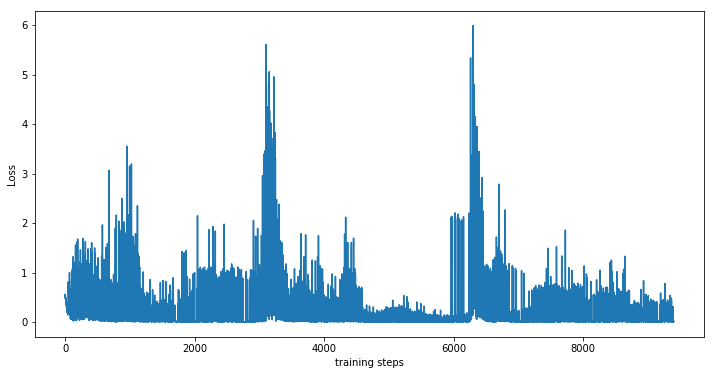

In [7]:
actor.plot_loss()

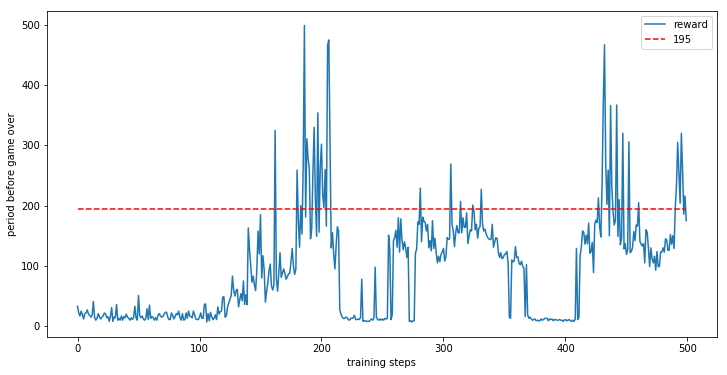

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(periods, label='reward')
plt.plot([195] * len(periods), c='r', linestyle='--', label='195')
plt.xlabel('training steps')
plt.ylabel('period before game over')
plt.legend();

### 5. Let's test your actor

In [10]:
frames = []
rewards = []

for episode in range(100):
    total_reward = 0
    
    state = env.reset()
    
    while True:
        # only collect the grame of the first episode
        if episode == 0:
            frame = env.render(mode='rgb_array')
            frames.append(frame)
        
        action = actor.choose_action(state)
        state_next, reward, done, info = env.step(action)
        
        total_reward += reward

        actor.store(state, action, reward, state_next, done)
            
        state = state_next
        
        if done:
            break
    
    print('Episode: {:3d}, reward: {:3d}'.format(episode, int(total_reward)))
    rewards.append(total_reward)

print('game over')

Episode:   0, reward: 237
Episode:   1, reward: 265
Episode:   2, reward: 206
Episode:   3, reward: 205
Episode:   4, reward: 241
Episode:   5, reward: 222
Episode:   6, reward: 247
Episode:   7, reward: 193
Episode:   8, reward: 191
Episode:   9, reward: 229
Episode:  10, reward: 243
Episode:  11, reward: 220
Episode:  12, reward: 232
Episode:  13, reward: 218
Episode:  14, reward: 236
Episode:  15, reward: 209
Episode:  16, reward: 213
Episode:  17, reward: 210
Episode:  18, reward: 213
Episode:  19, reward: 233
Episode:  20, reward: 192
Episode:  21, reward: 225
Episode:  22, reward: 207
Episode:  23, reward: 213
Episode:  24, reward: 228
Episode:  25, reward: 208
Episode:  26, reward: 267
Episode:  27, reward: 207
Episode:  28, reward: 199
Episode:  29, reward: 239
Episode:  30, reward: 222
Episode:  31, reward: 205
Episode:  32, reward: 209
Episode:  33, reward: 206
Episode:  34, reward: 207
Episode:  35, reward: 225
Episode:  36, reward: 196
Episode:  37, reward: 237
Episode:  38

##### Wow! Your actor is so smart!

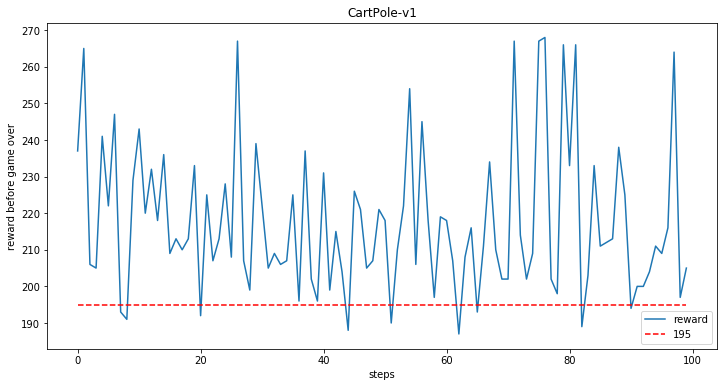

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='reward')
plt.plot([195] * len(rewards), c='r', linestyle='--', label='195')
plt.xlabel('steps')
plt.ylabel('reward before game over')
plt.title('CartPole-v1')
plt.legend();

### 6. Let's generate an animation to show off

In [12]:
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display
from JSAnimation.IPython_display import display_animation
%matplotlib inline

In [13]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))
    
    return anim

In [14]:
def save_animation(anim, savepath):
    assert savepath.endswith('.mp4')
    
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    anim.save(savepath, writer=writer)
    
    print('Save animation completed')


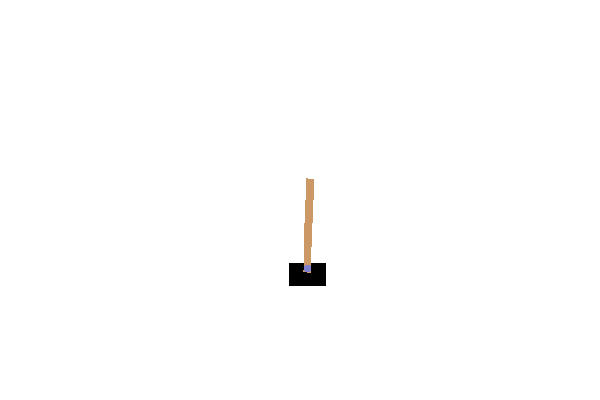
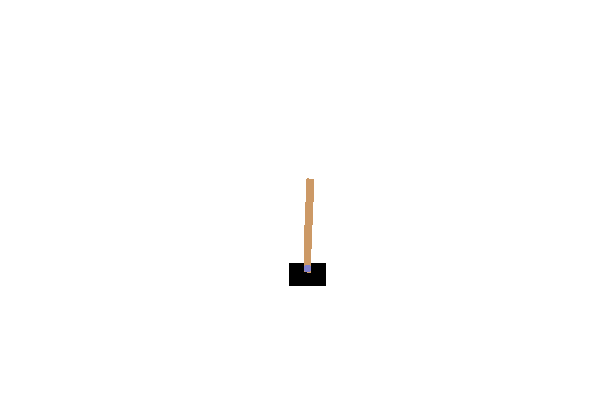
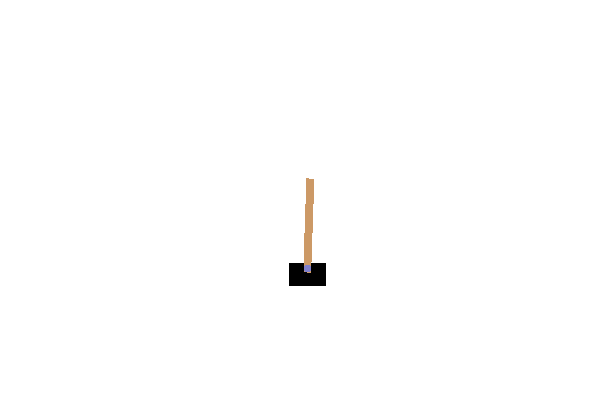
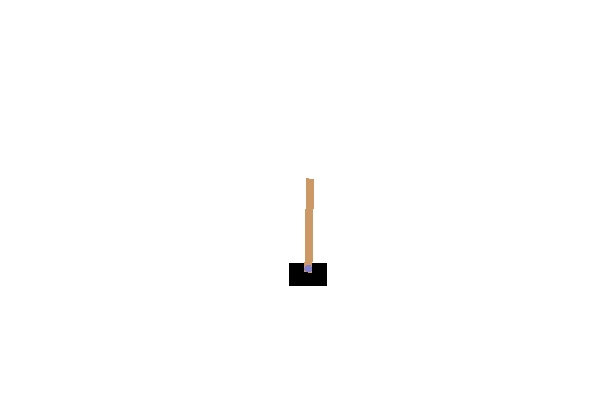
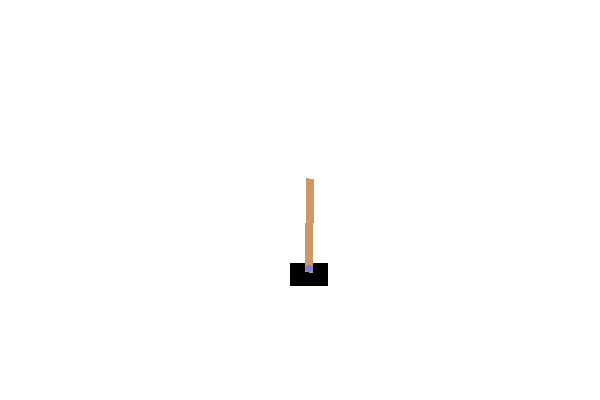
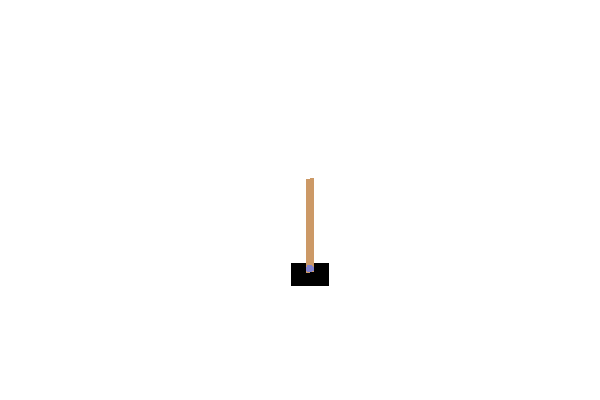
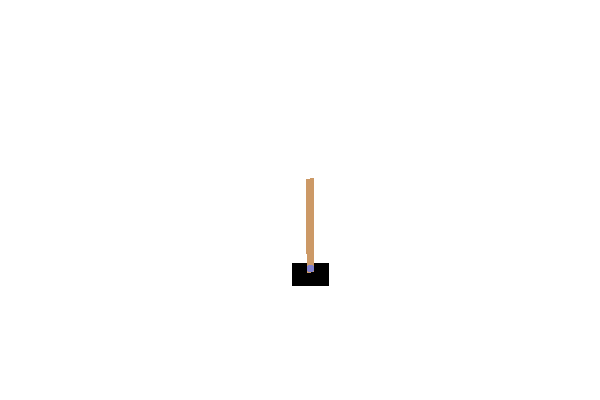
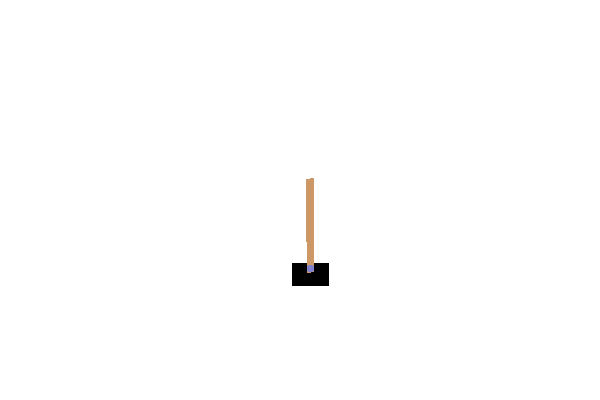
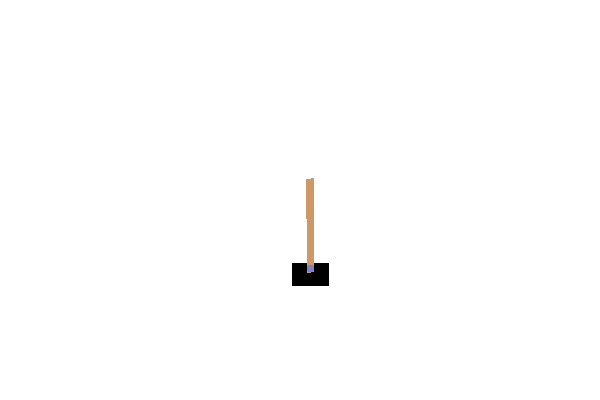
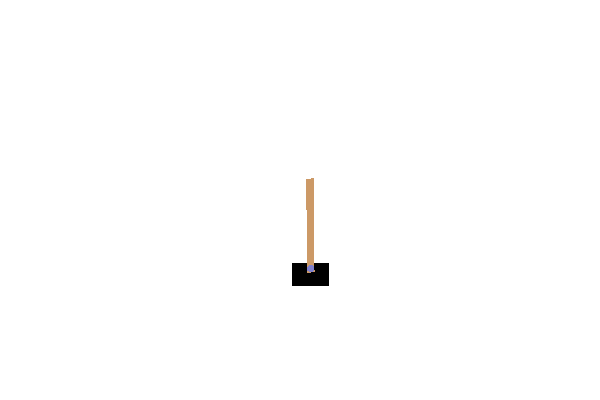
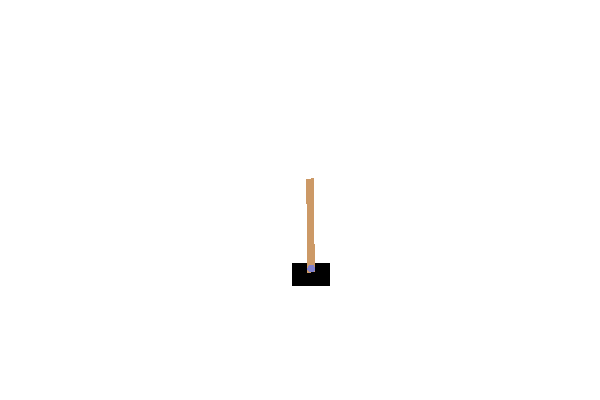
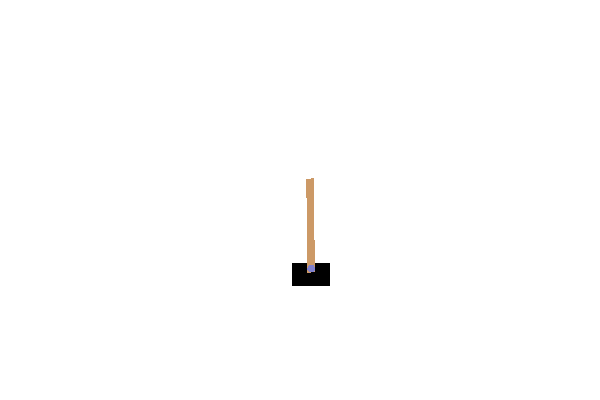
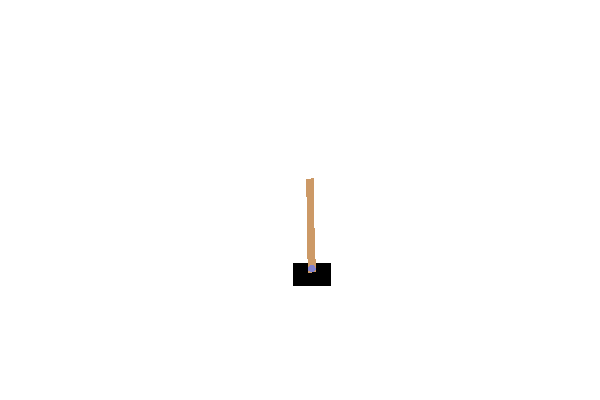
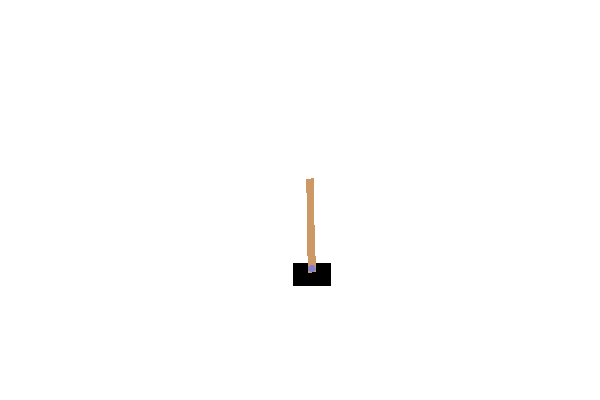
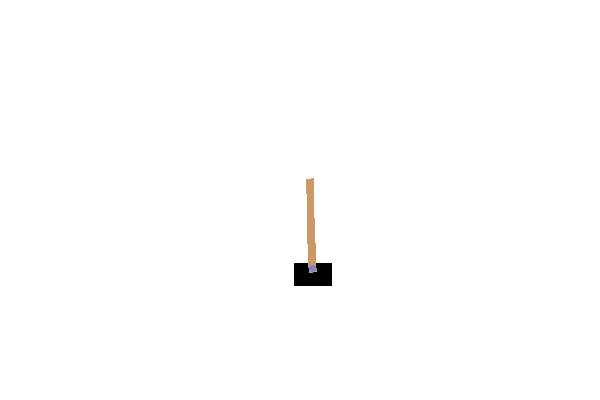
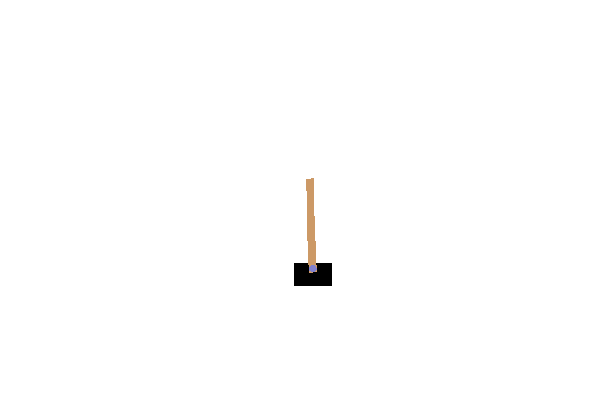
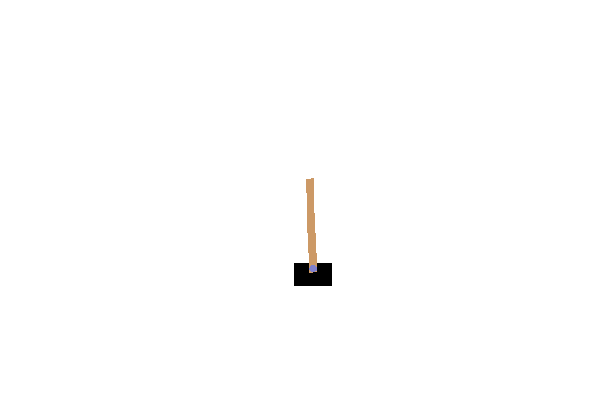
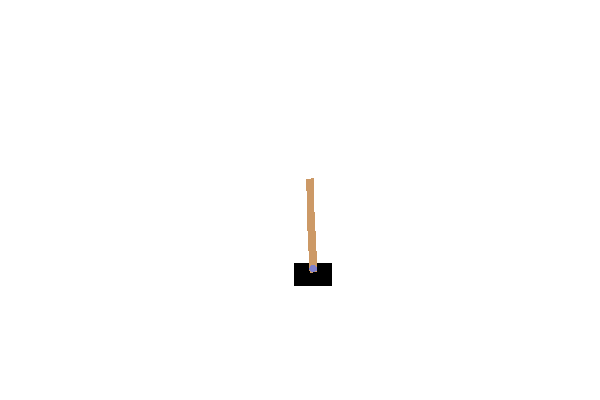
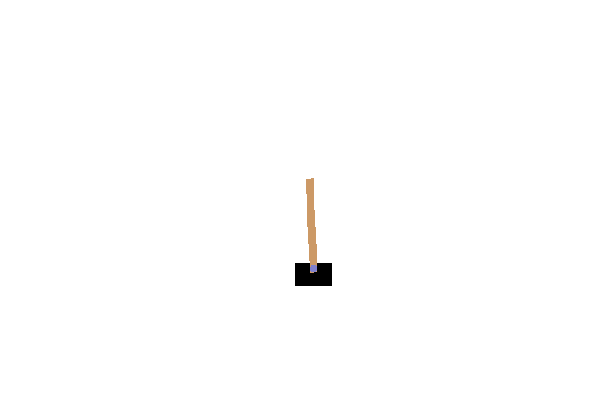
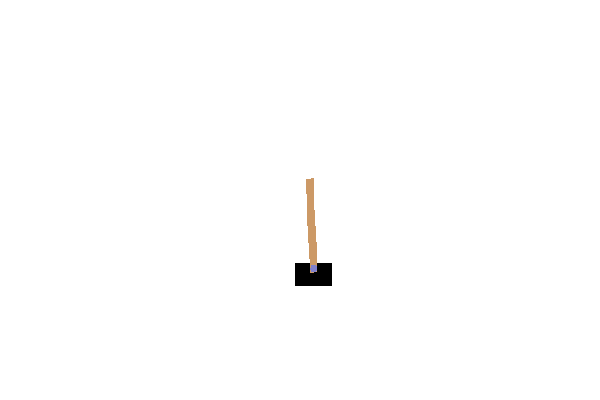
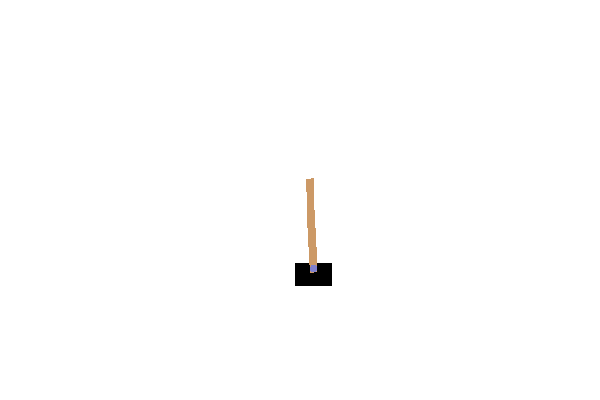
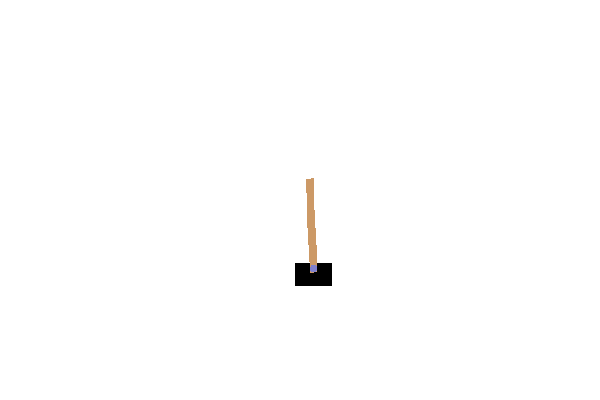
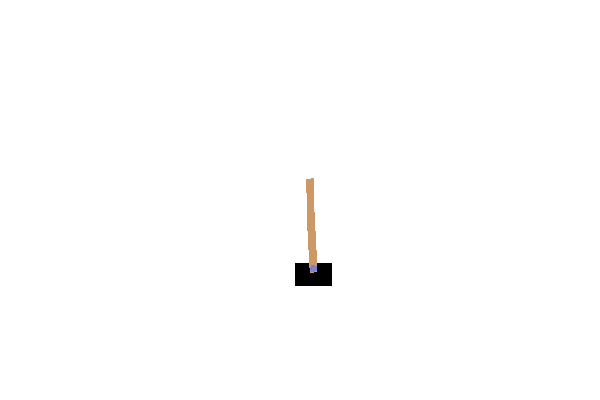
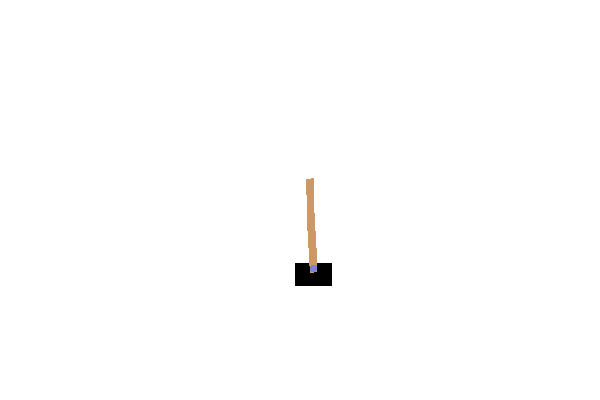
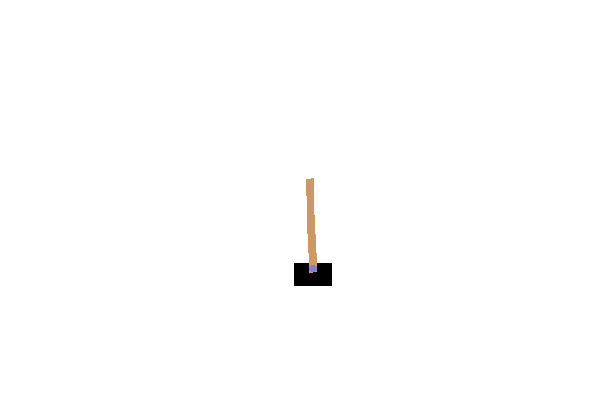
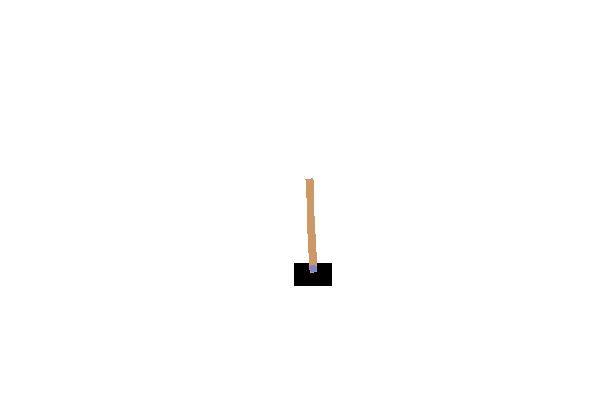
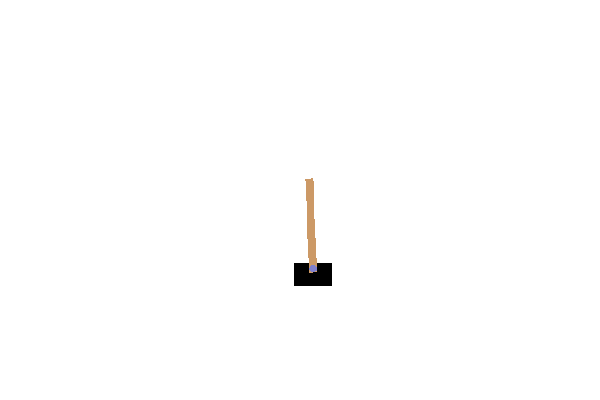
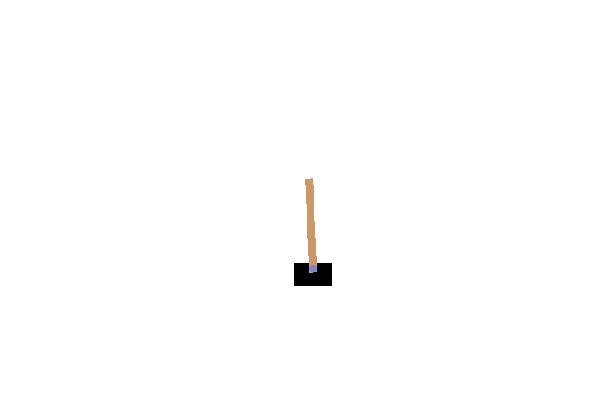
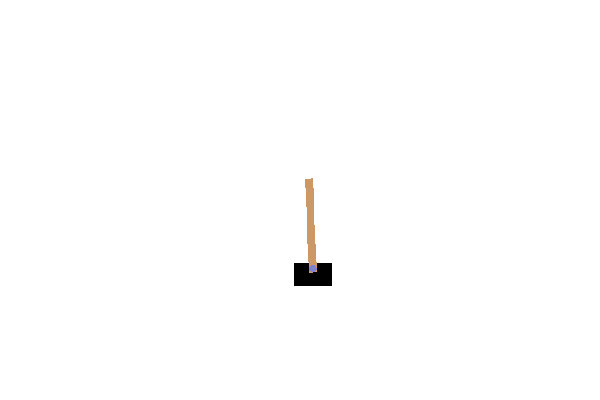
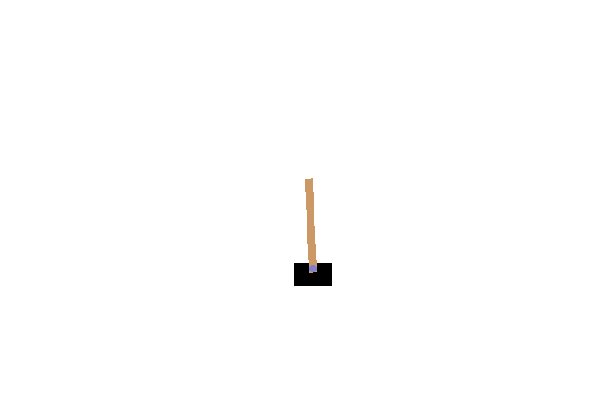
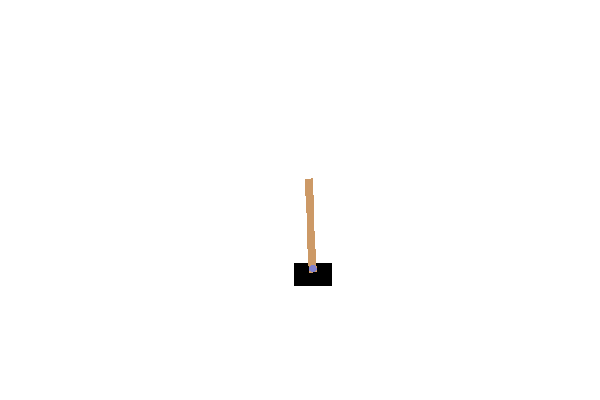
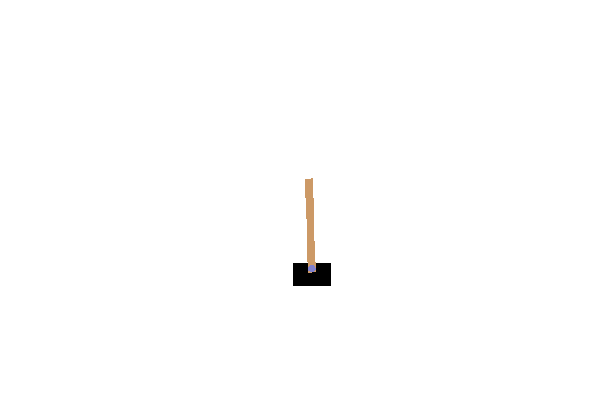
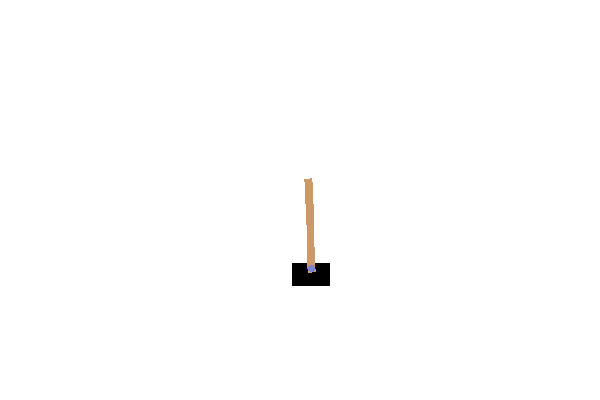
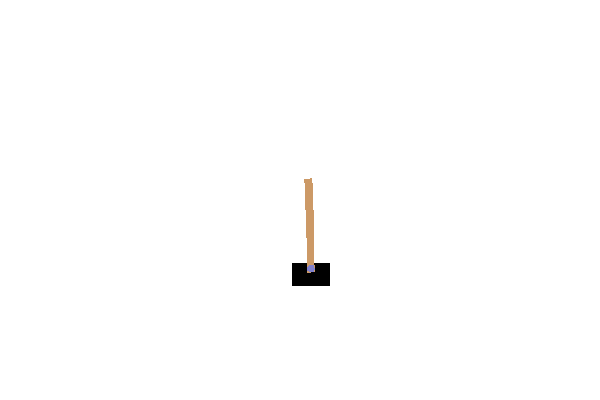
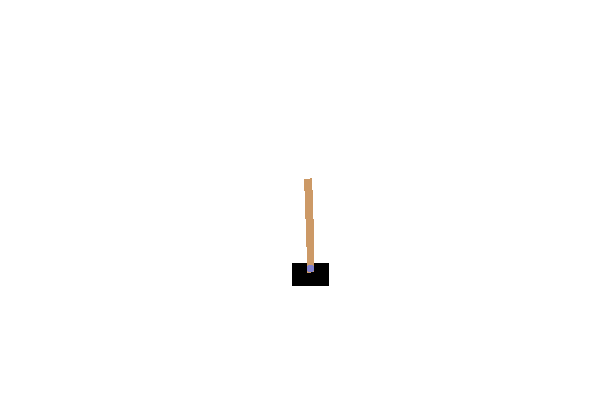
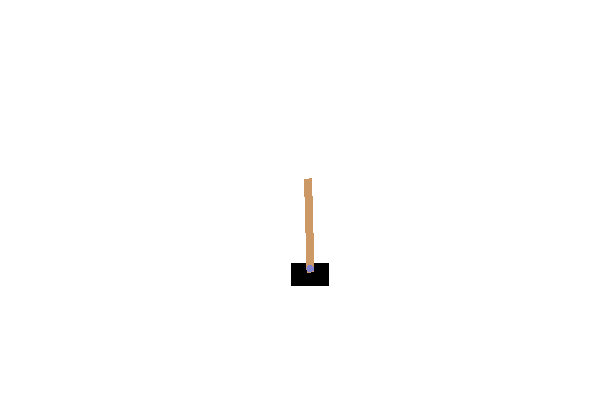
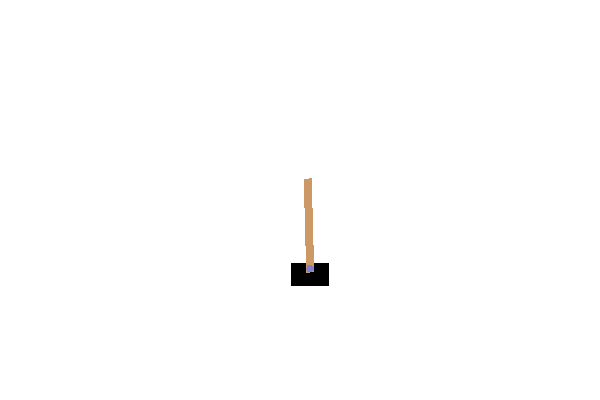
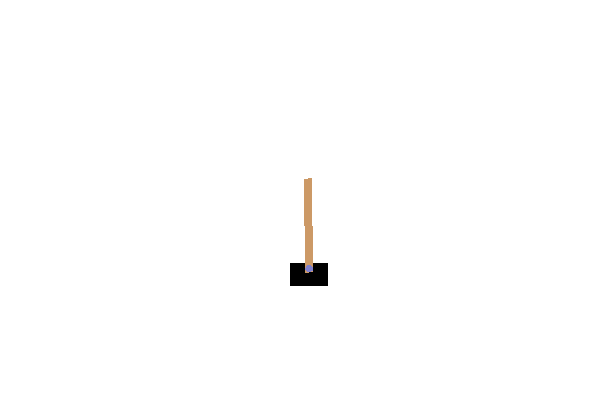
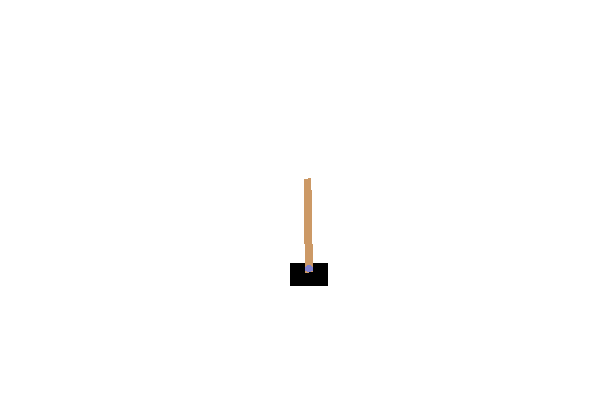
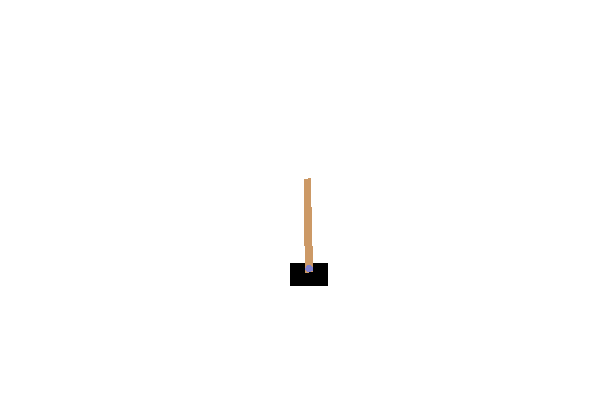
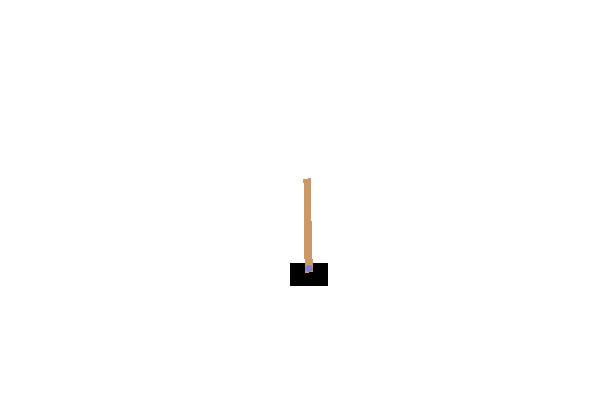
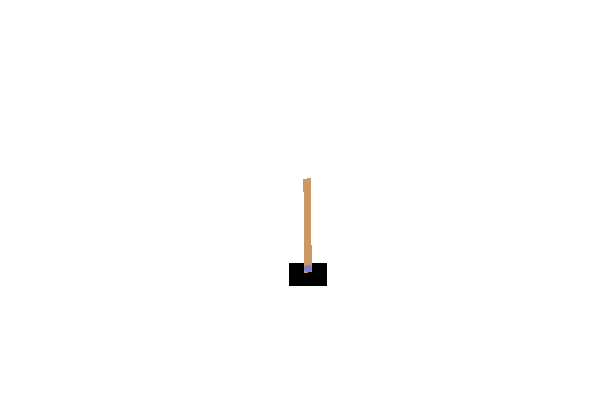
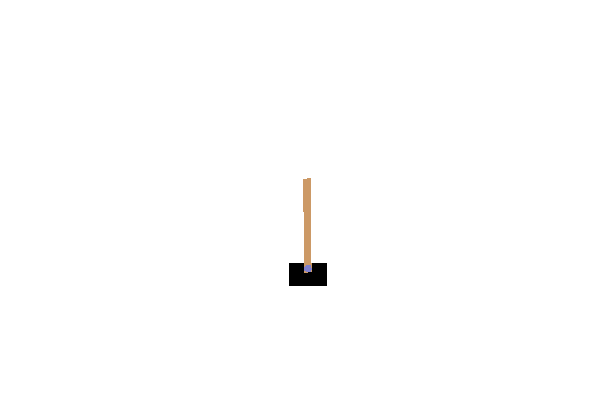
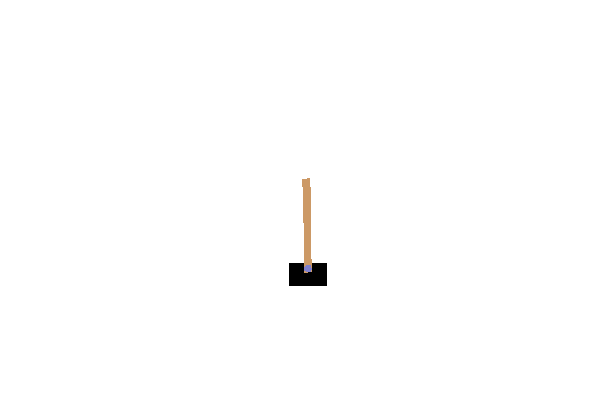
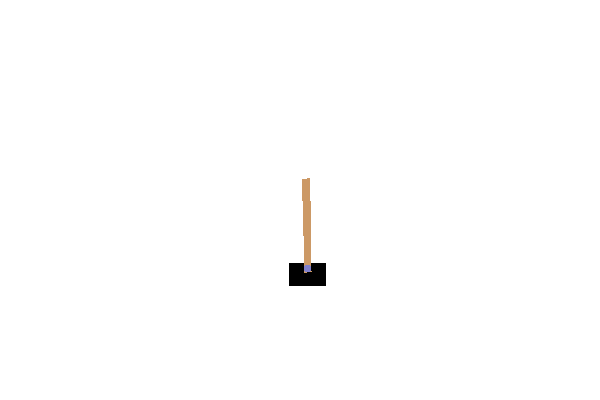
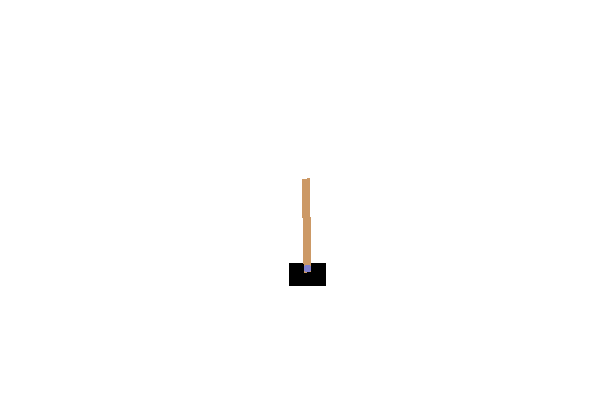
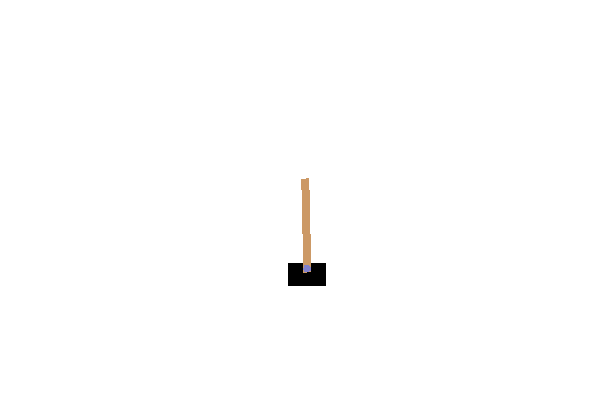
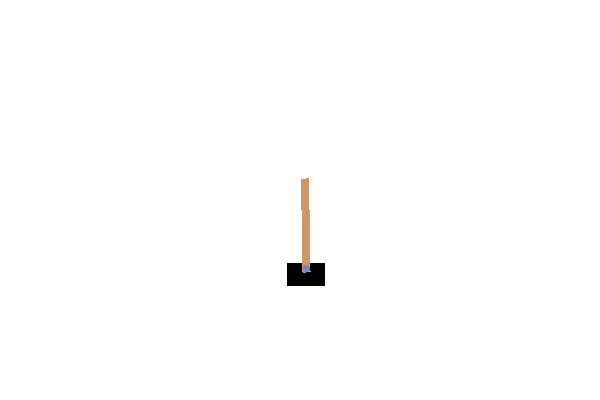
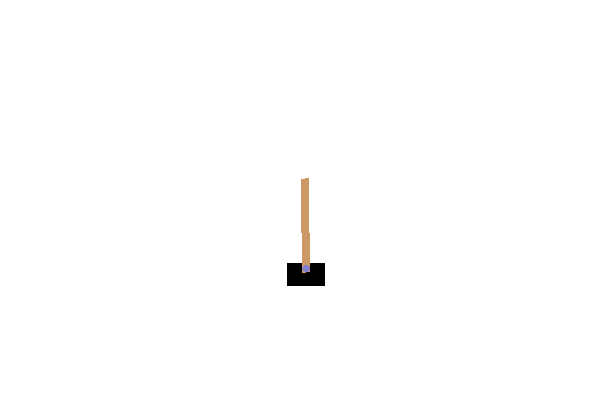
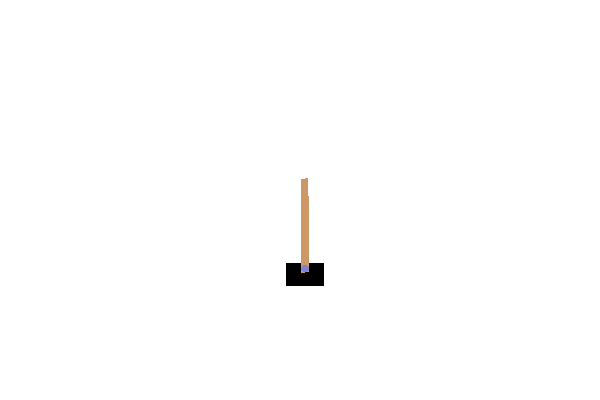
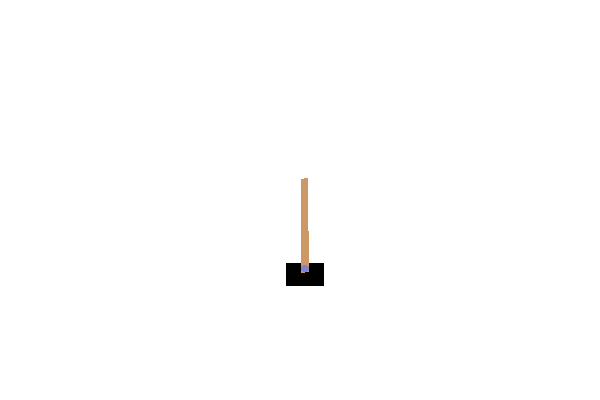
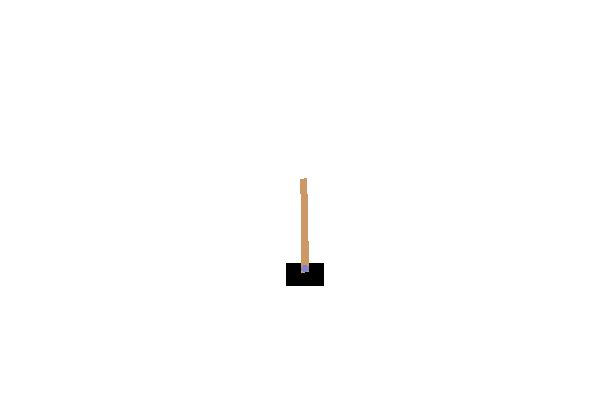
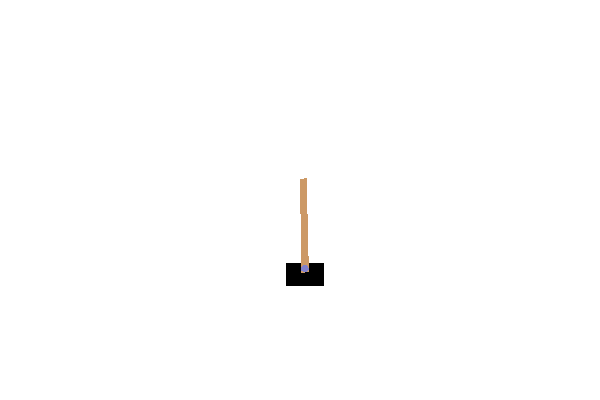
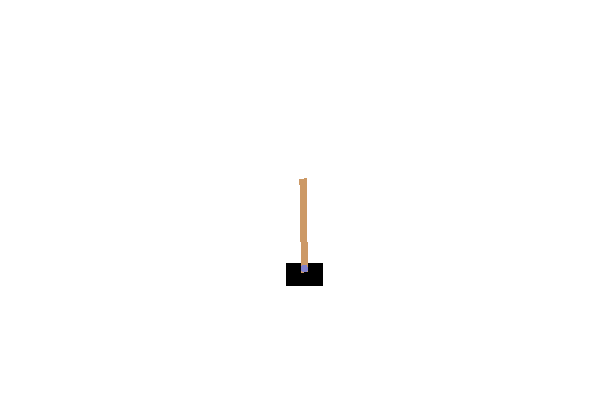
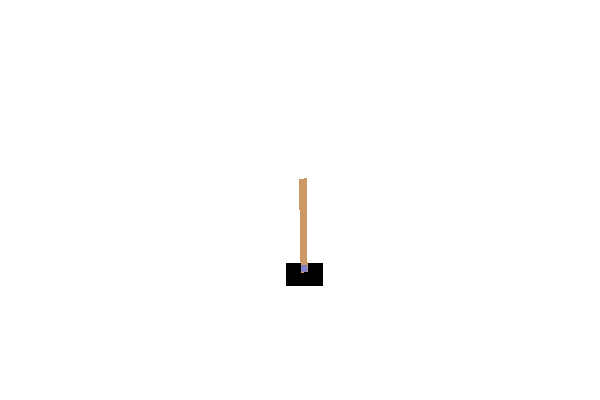
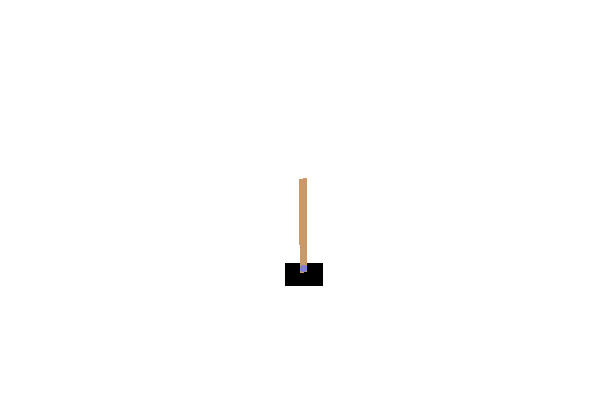
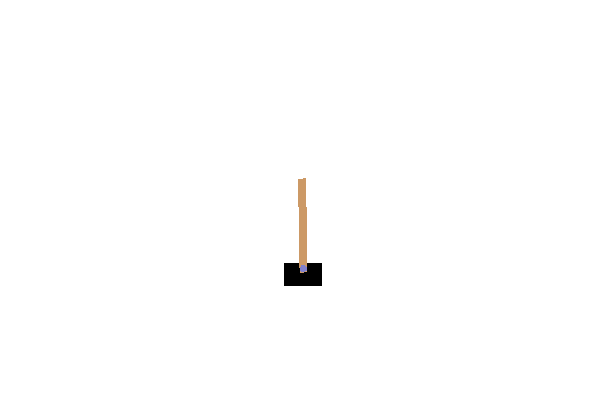
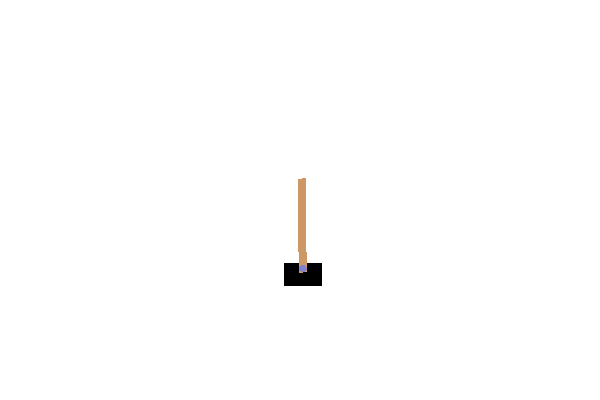
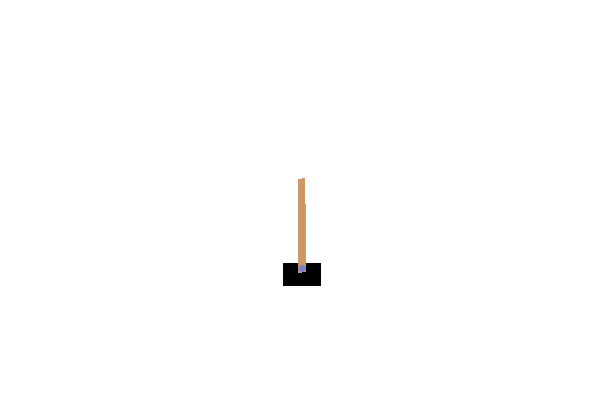
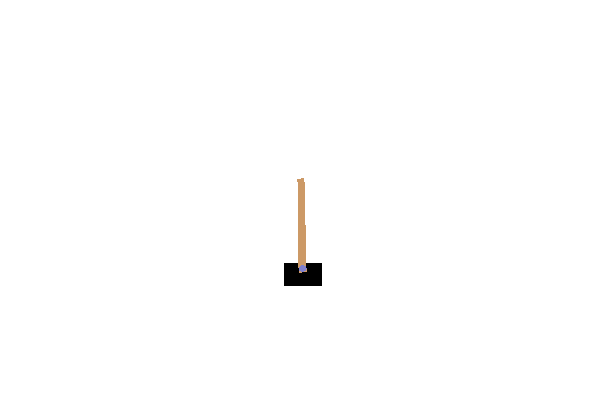
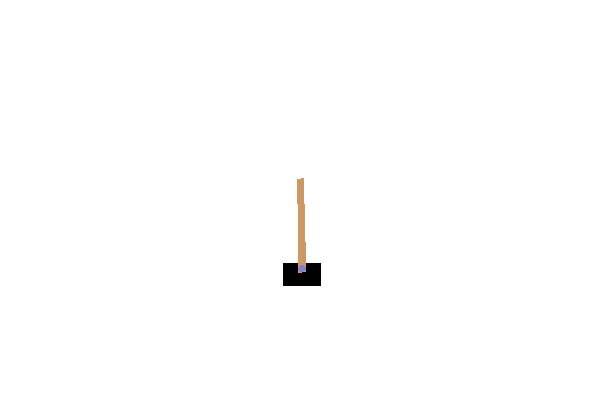
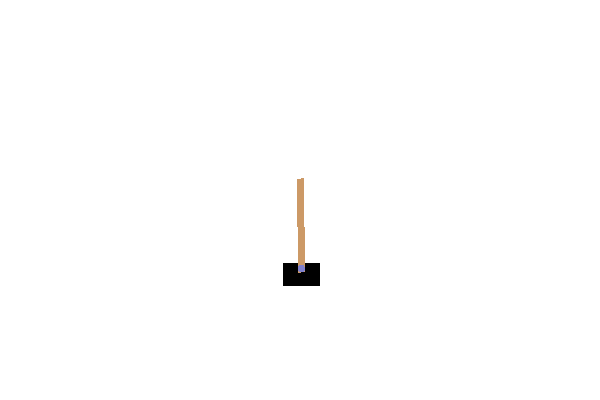
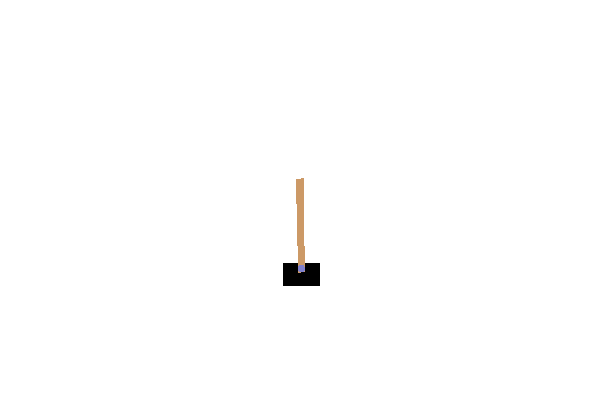
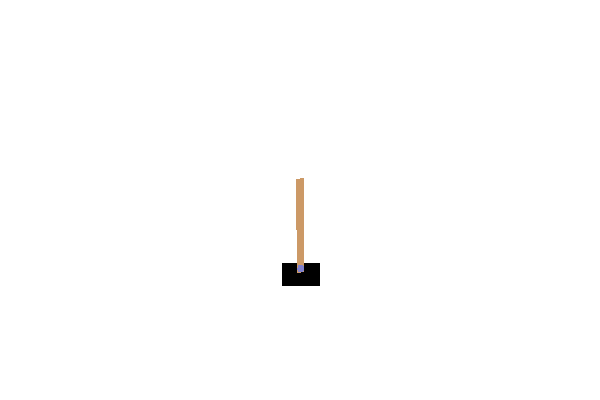
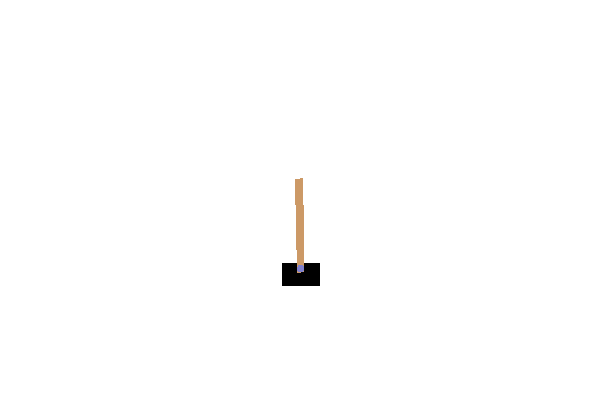
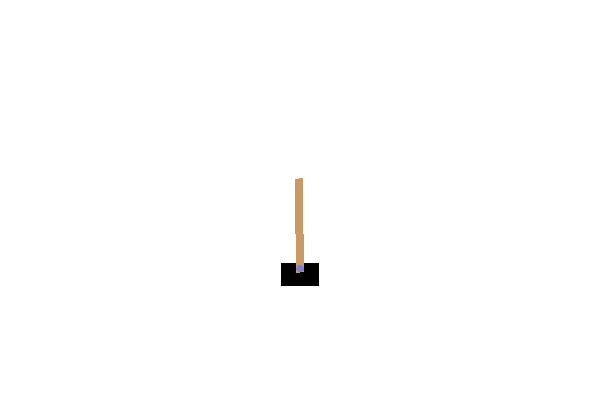
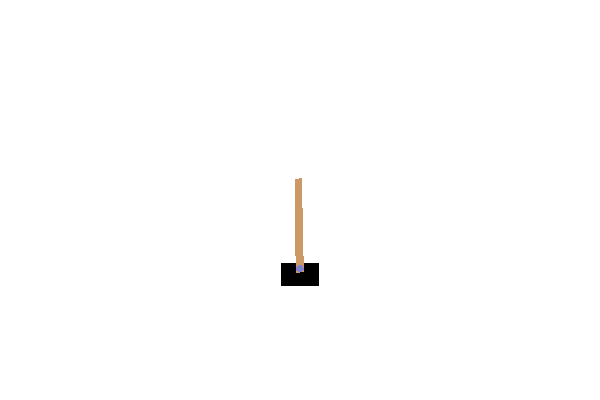
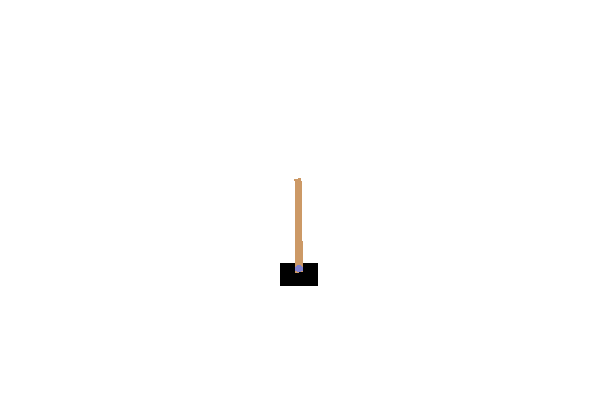
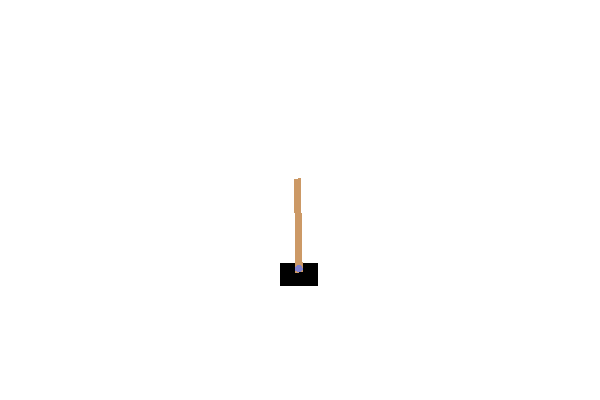
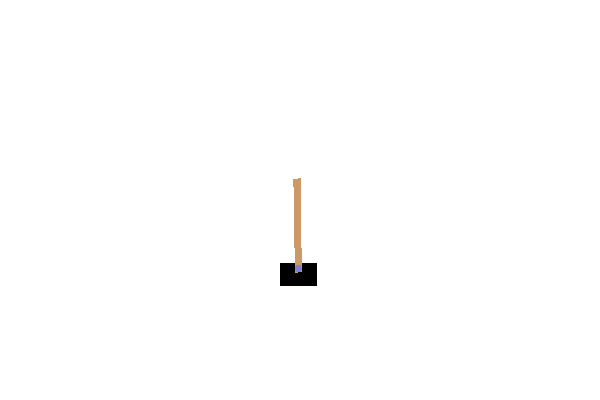
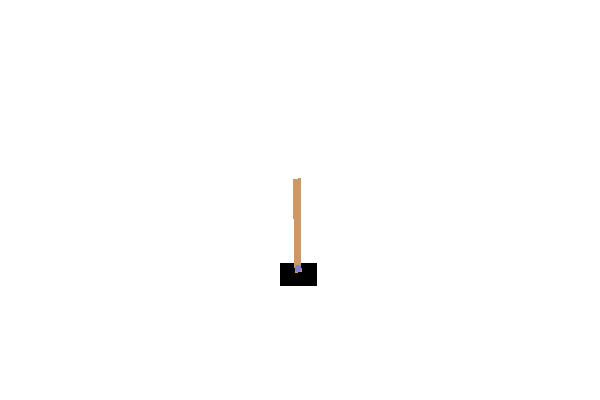
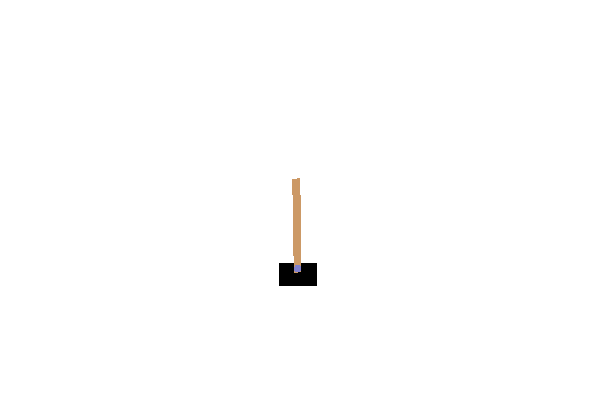
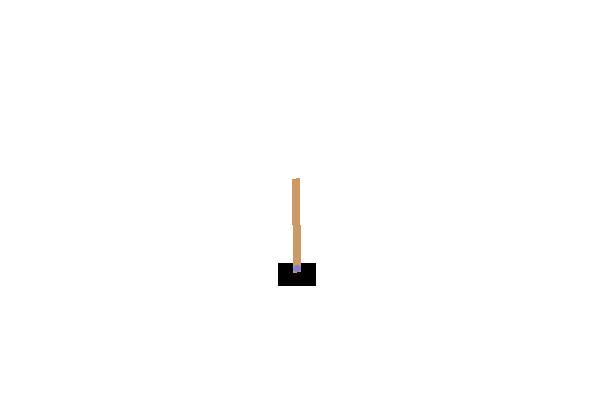
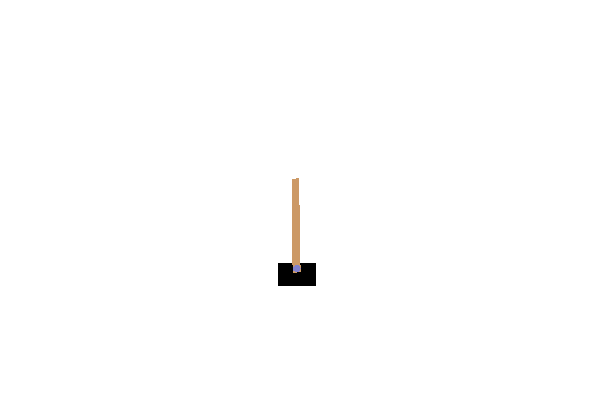
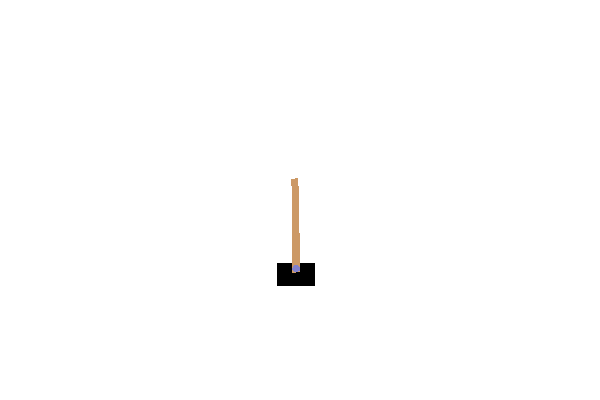
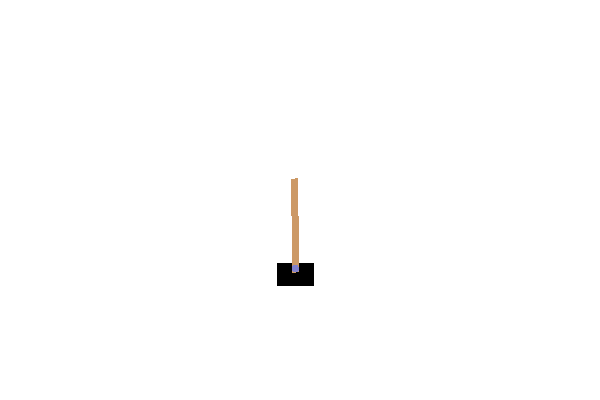
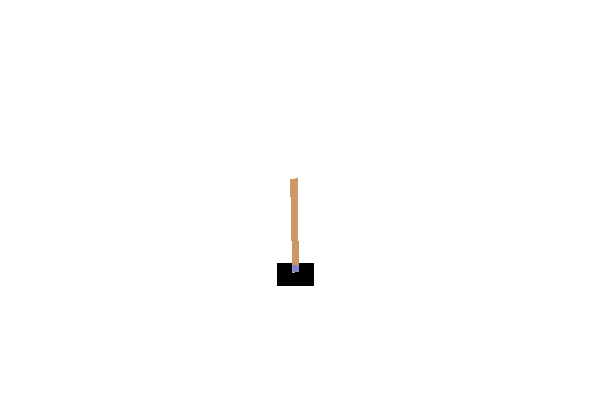
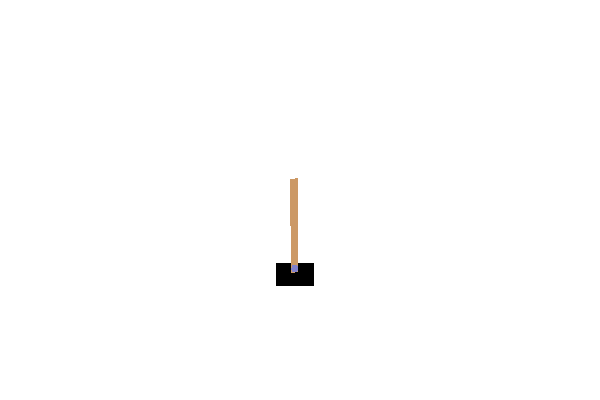
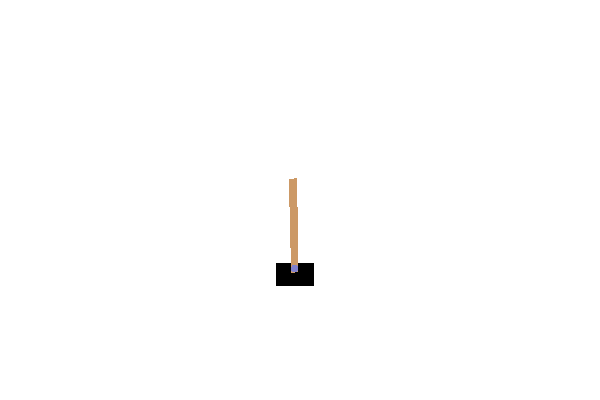
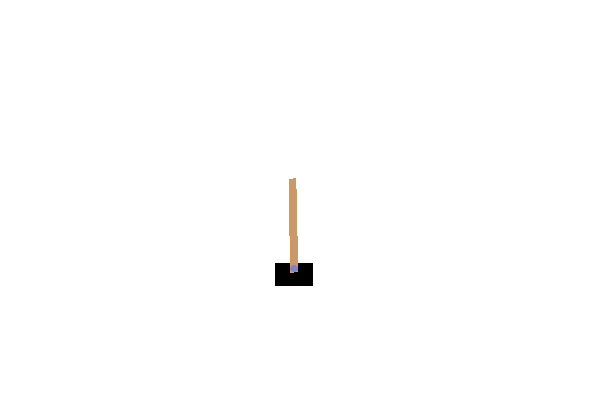
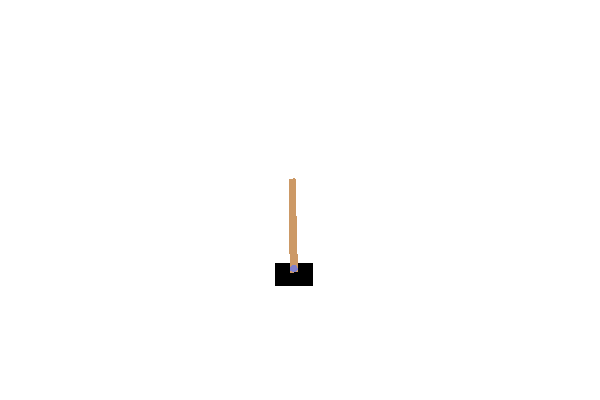
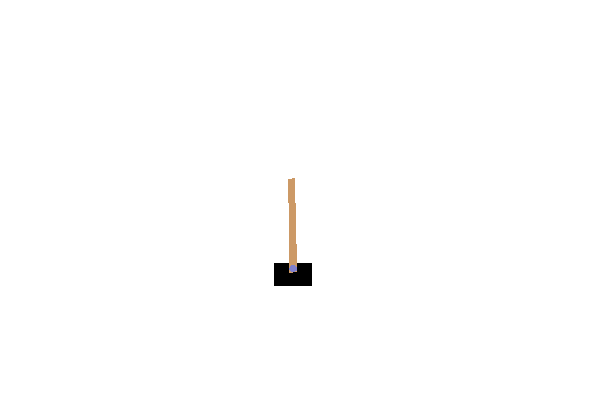
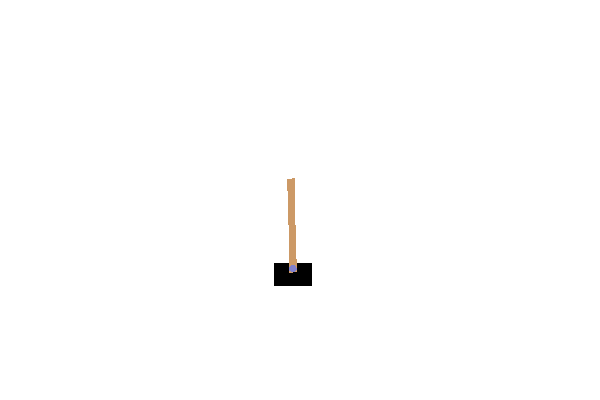
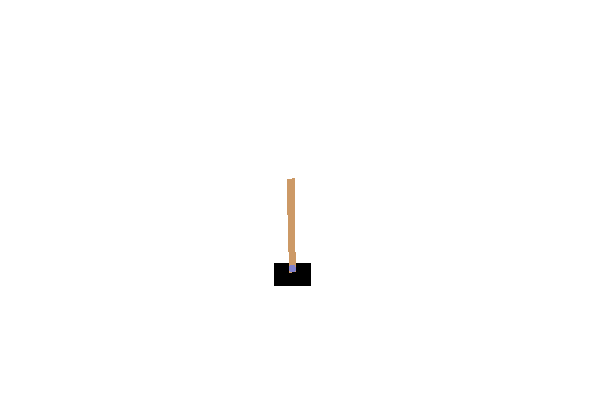
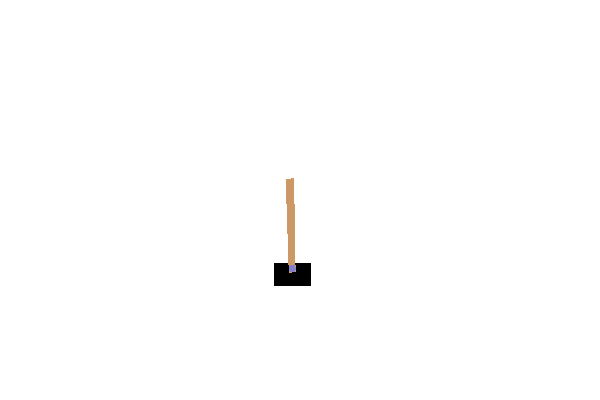
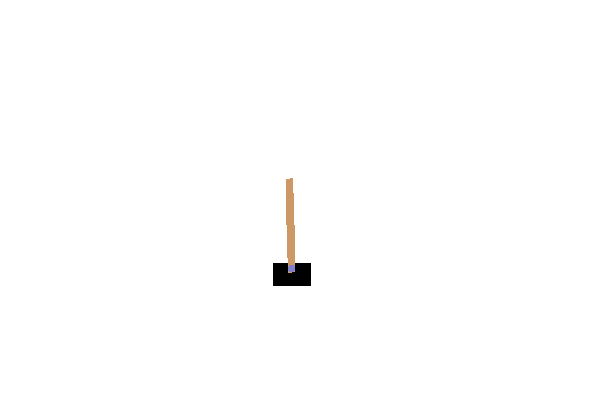
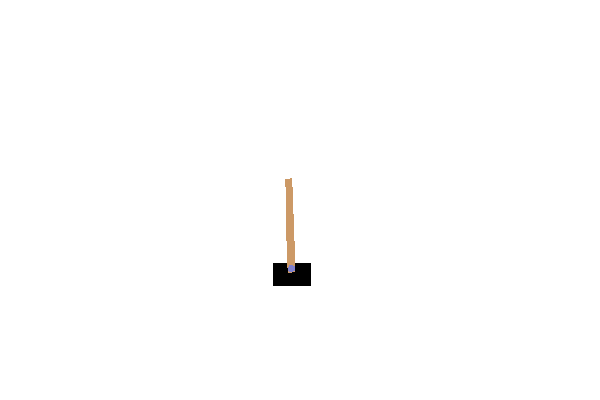
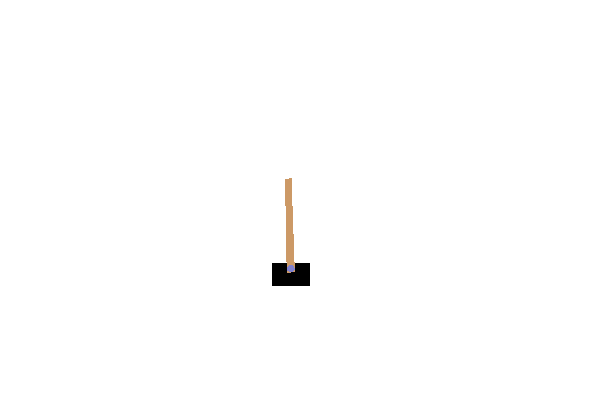
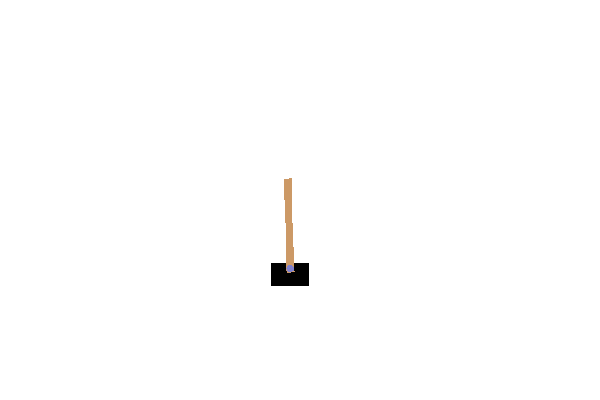
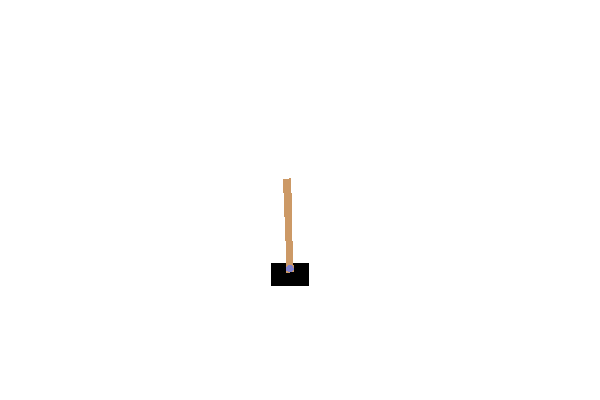
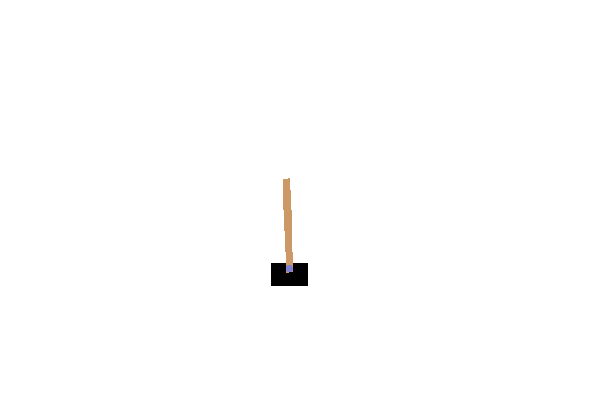
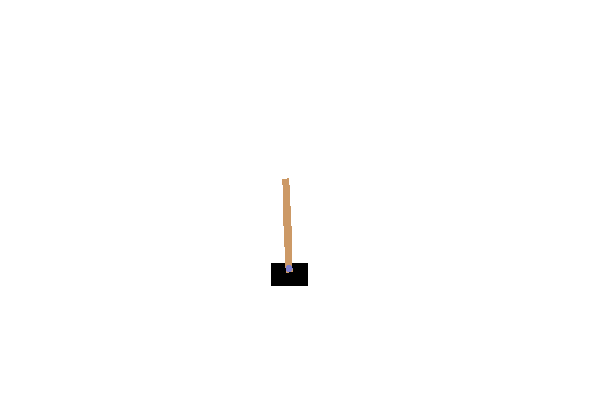
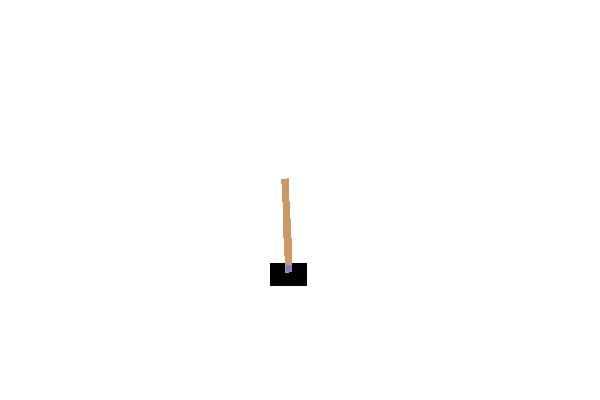
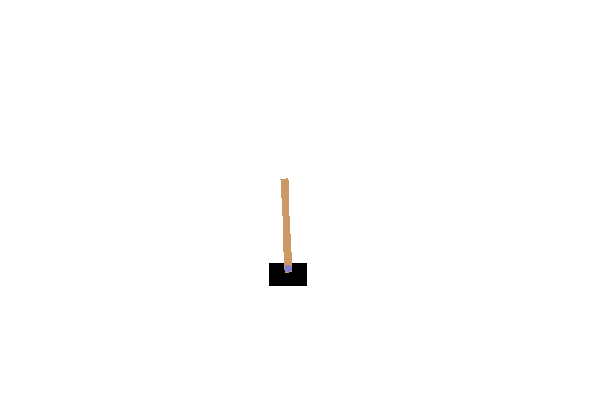
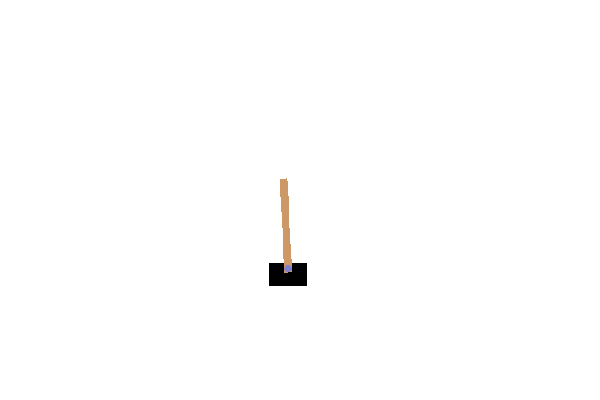
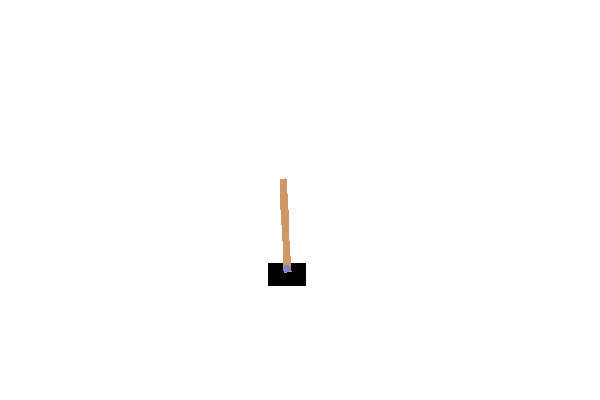
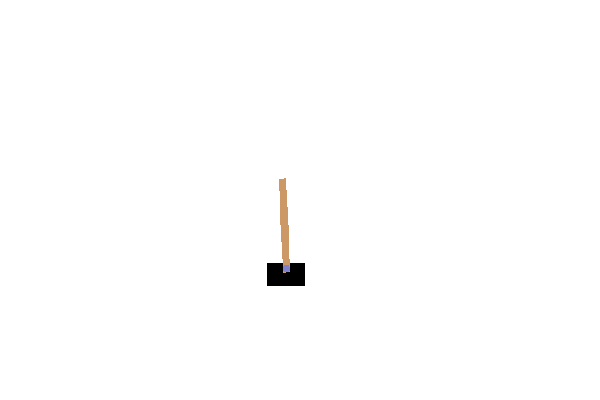
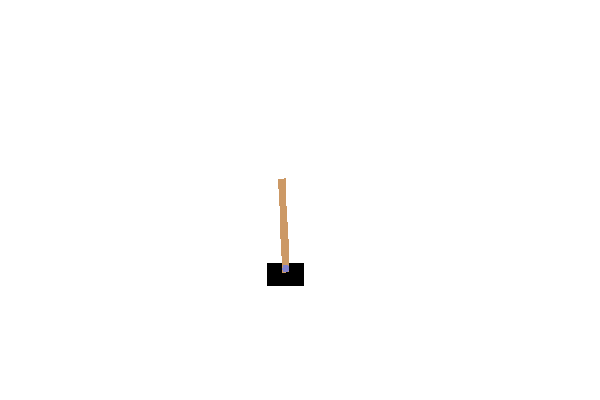
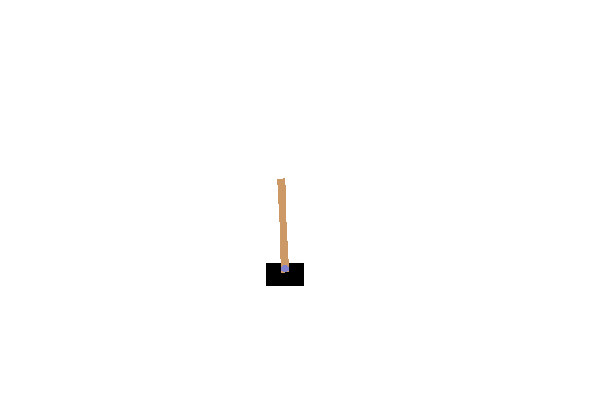
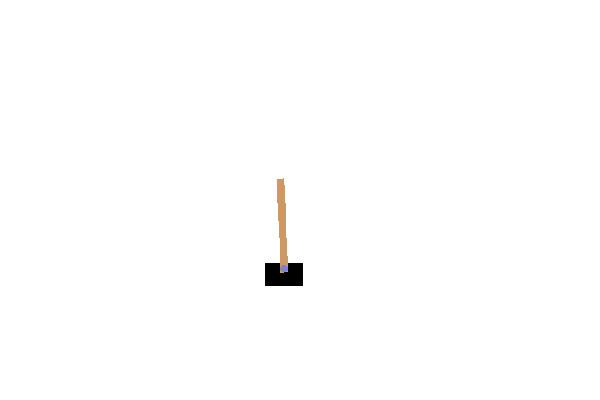
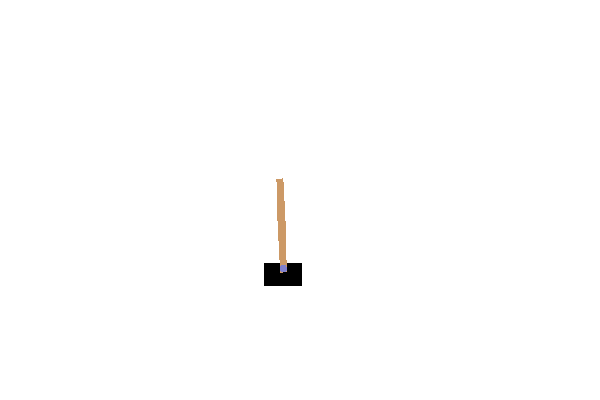
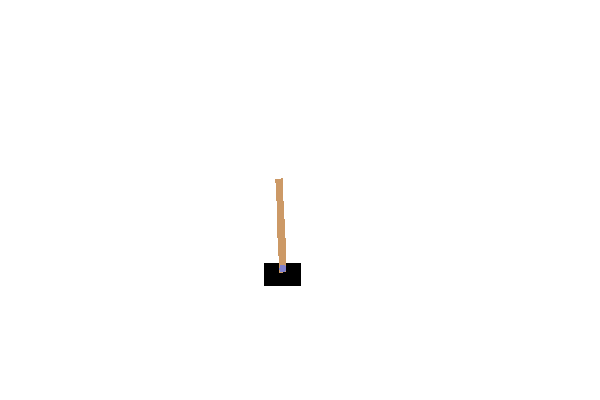
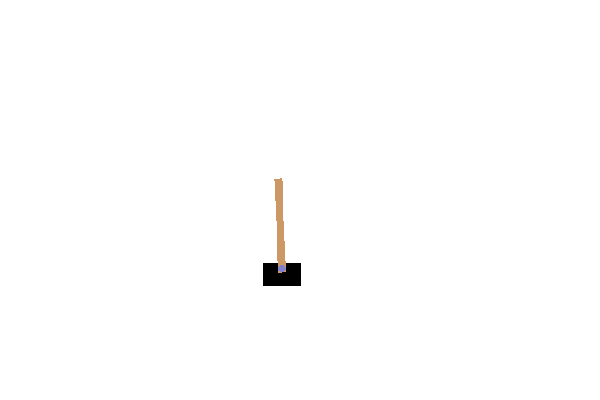
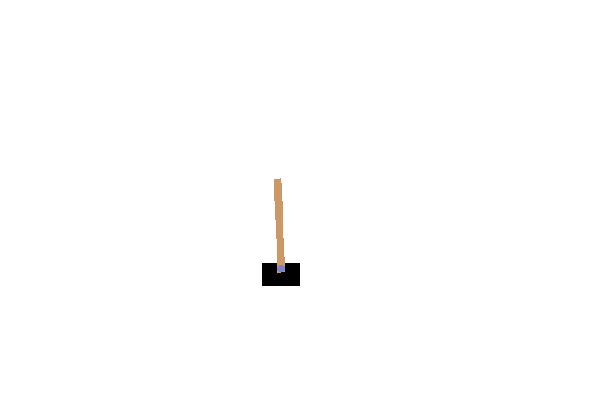
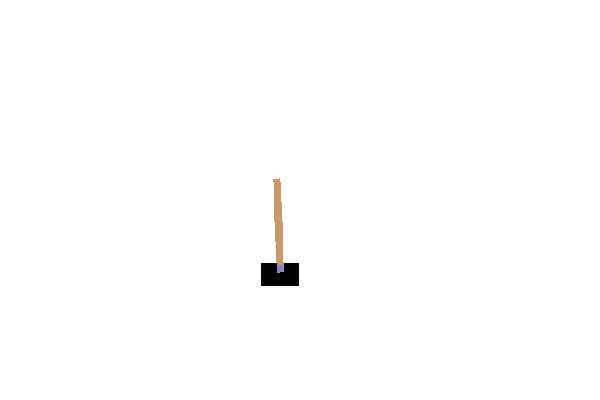
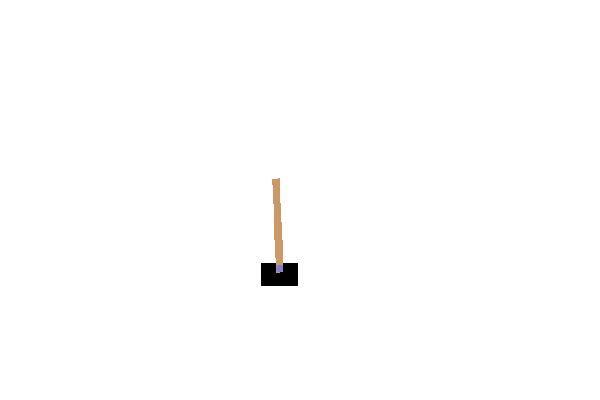
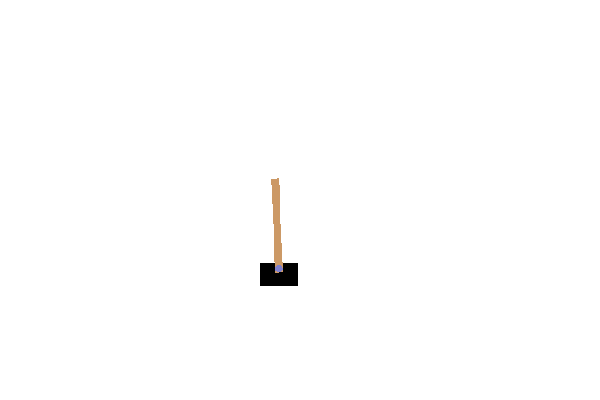
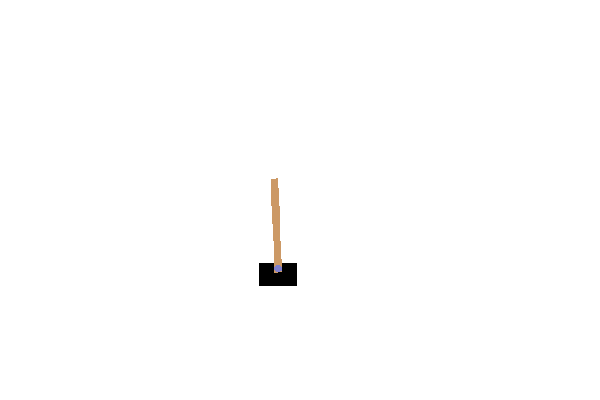
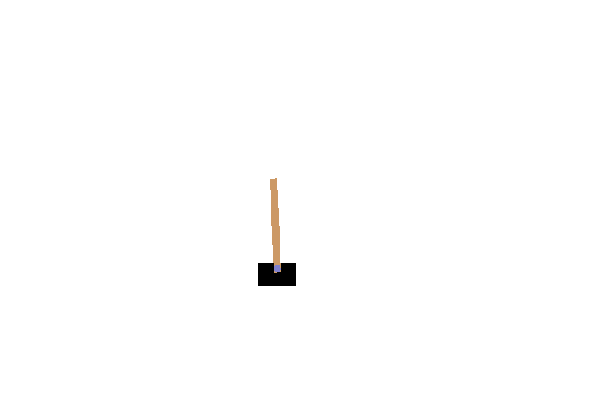
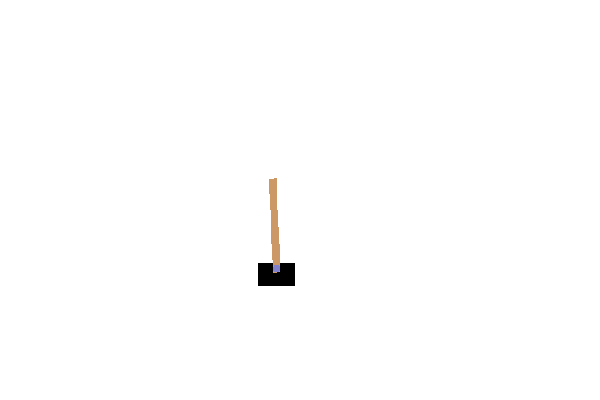
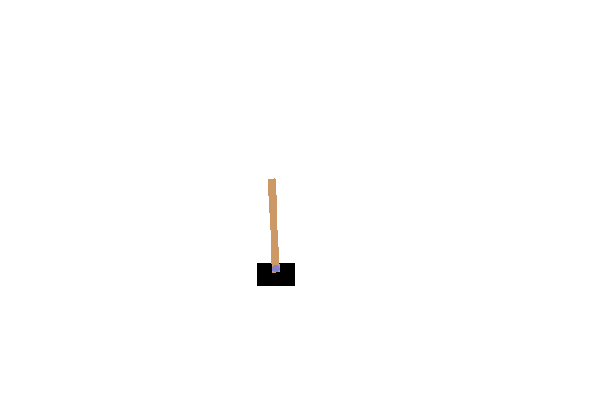
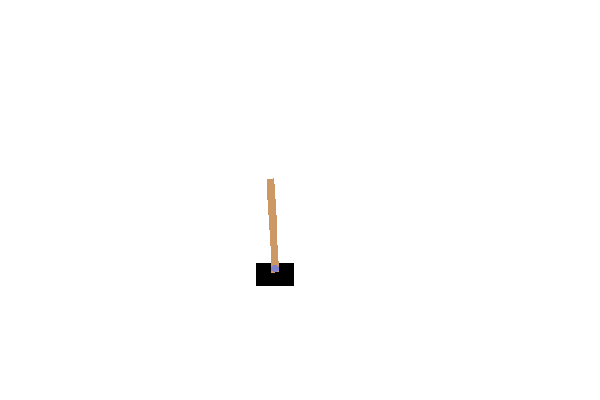
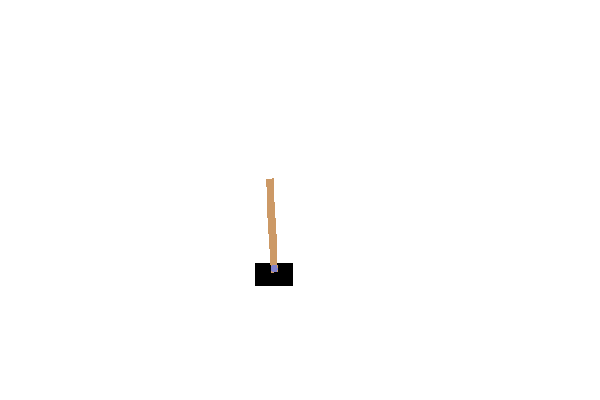
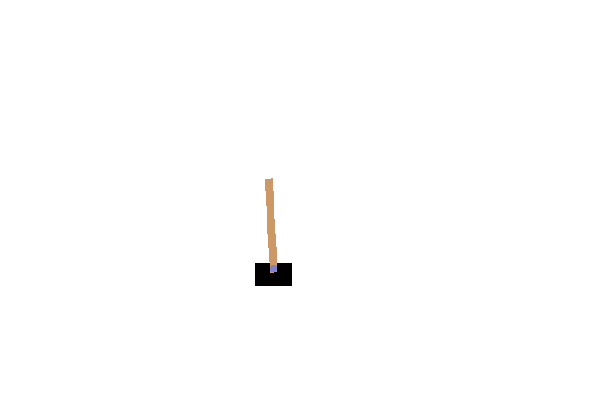
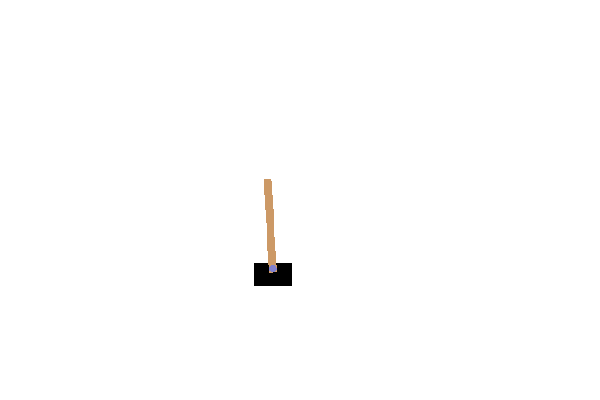
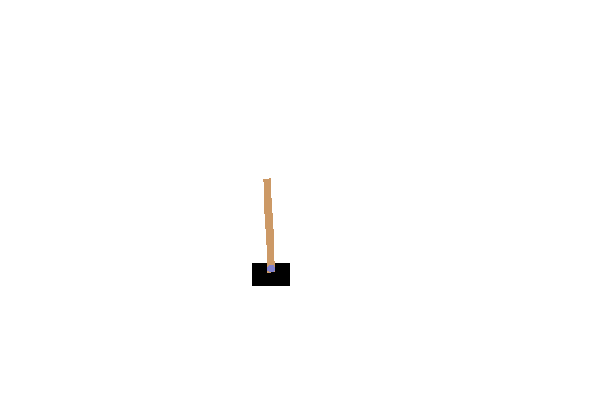
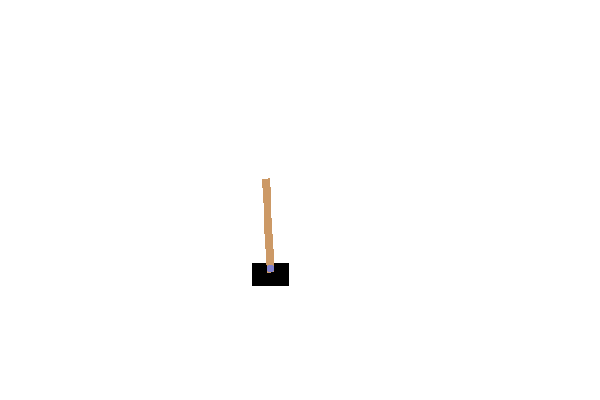
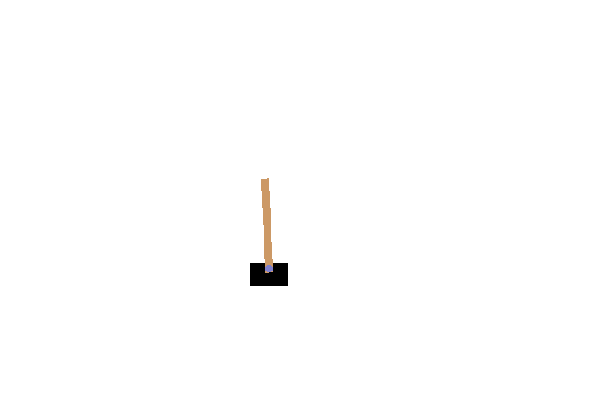
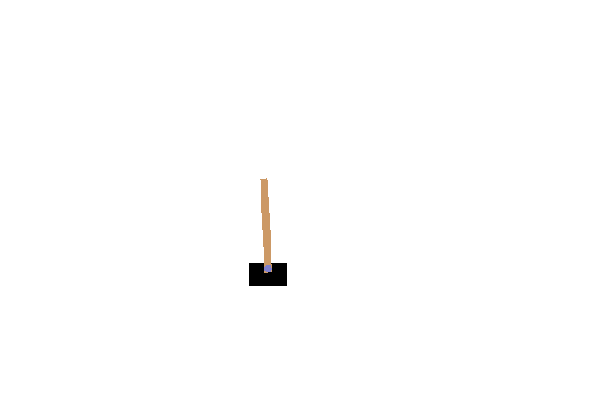
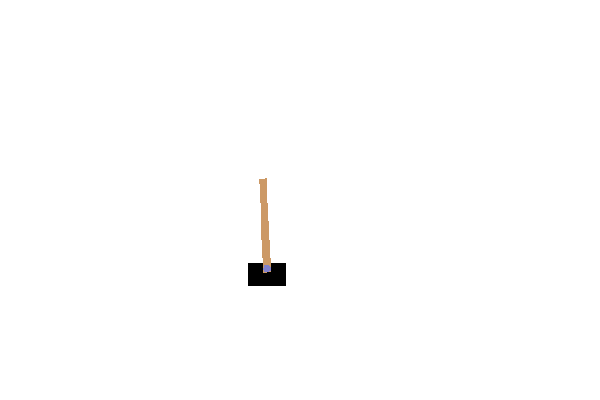
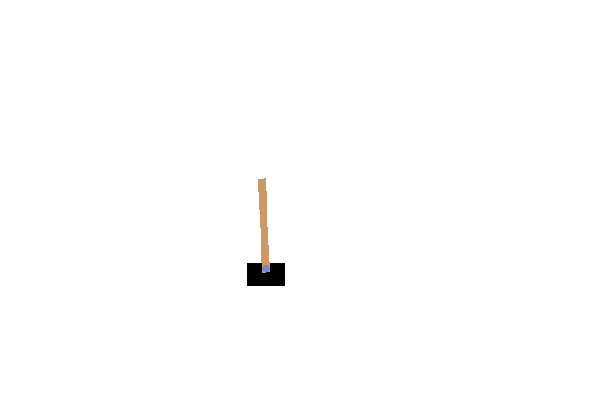
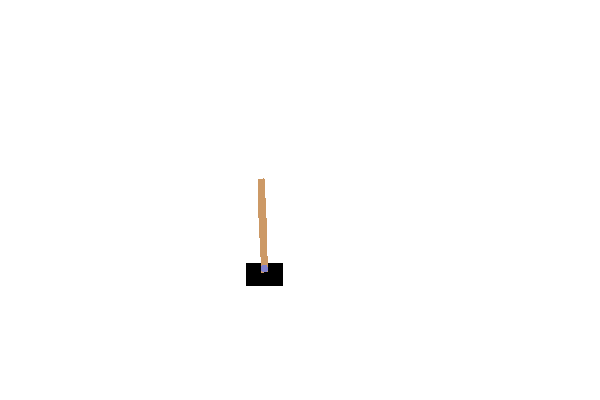
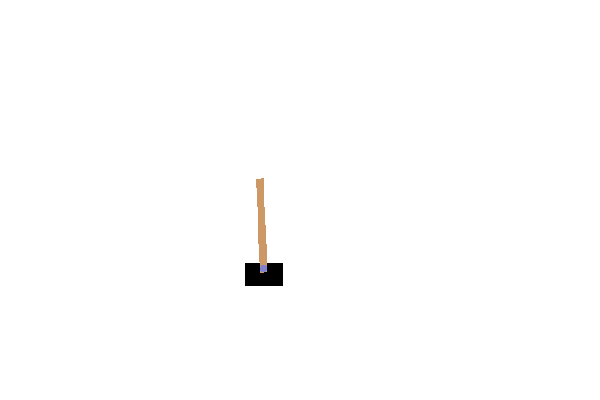
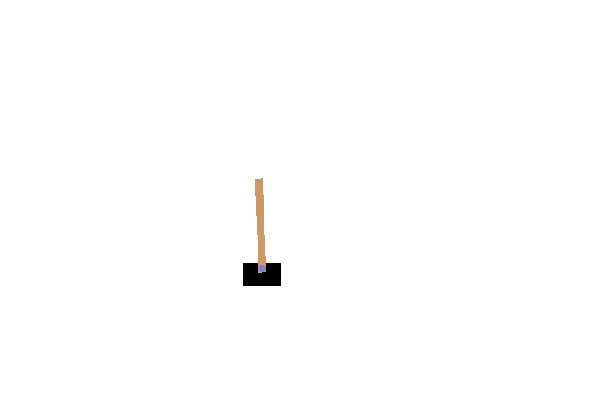
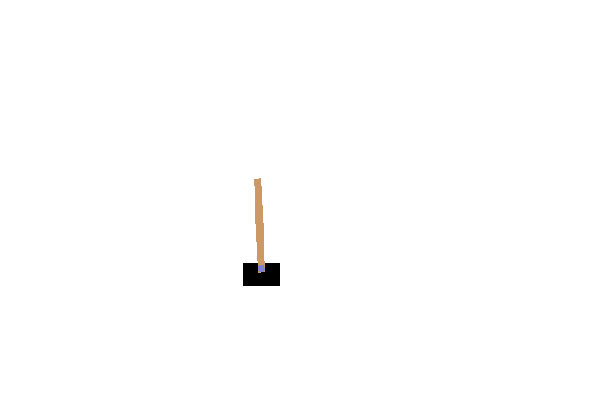
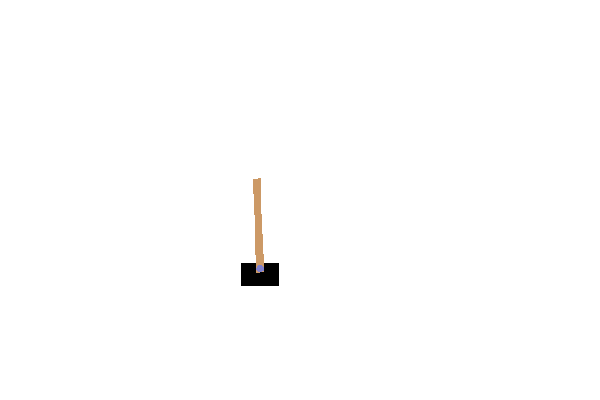
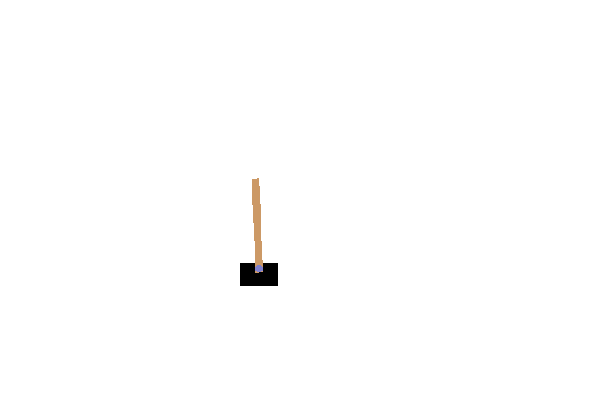
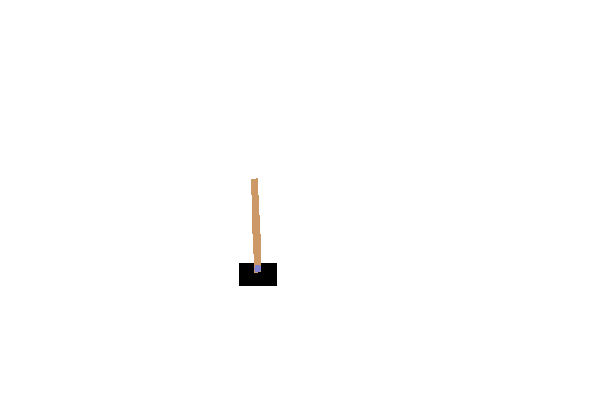
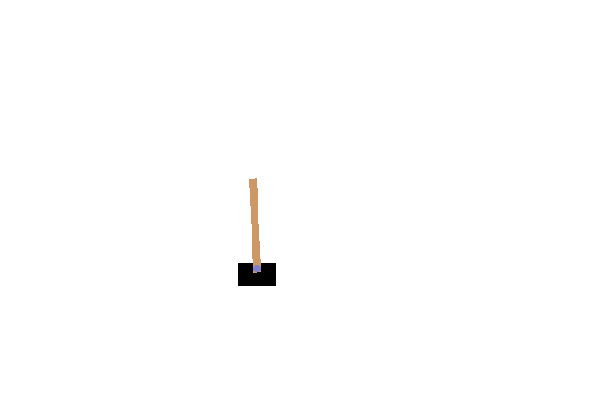
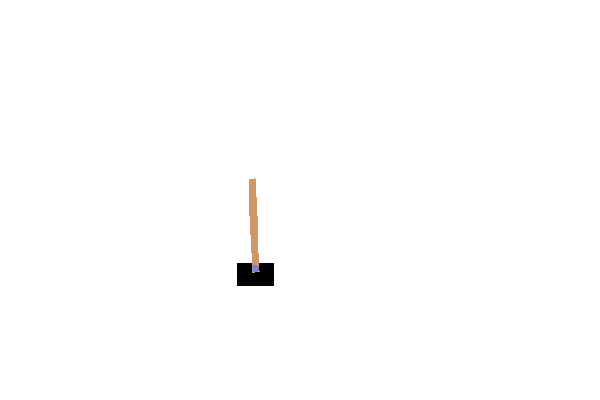
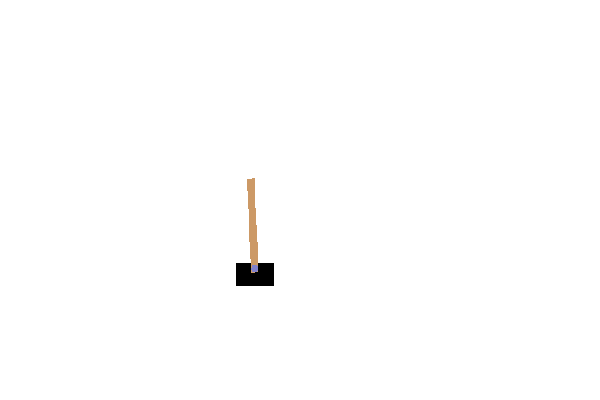
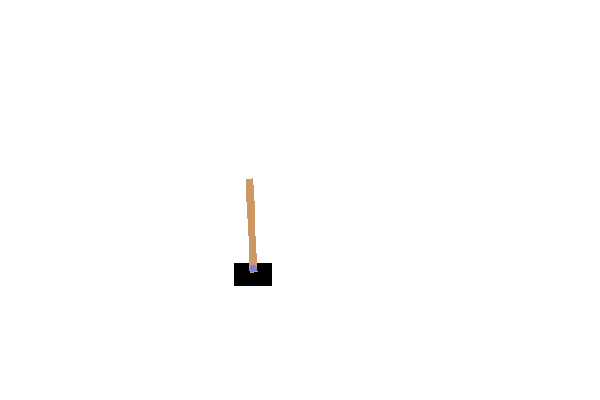
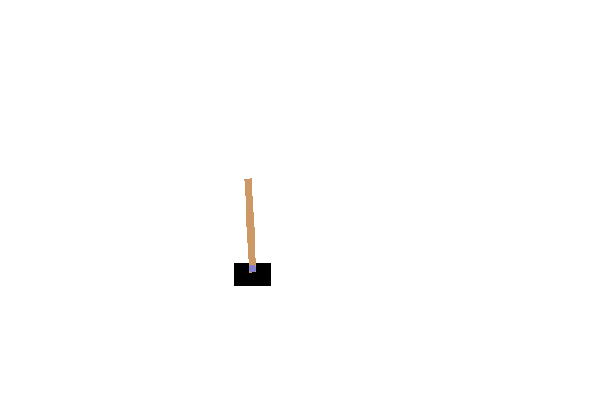
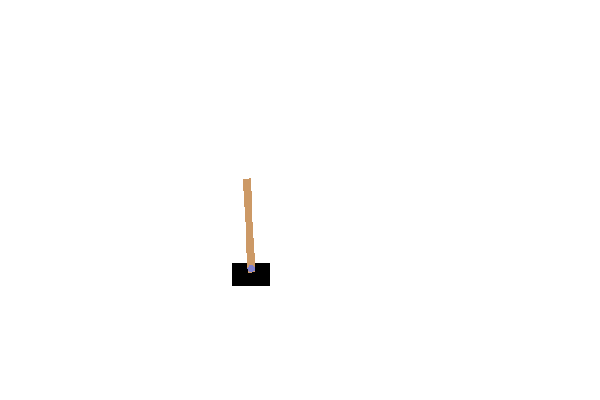
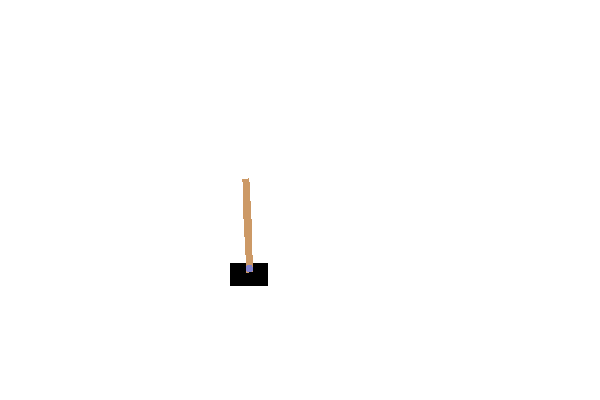
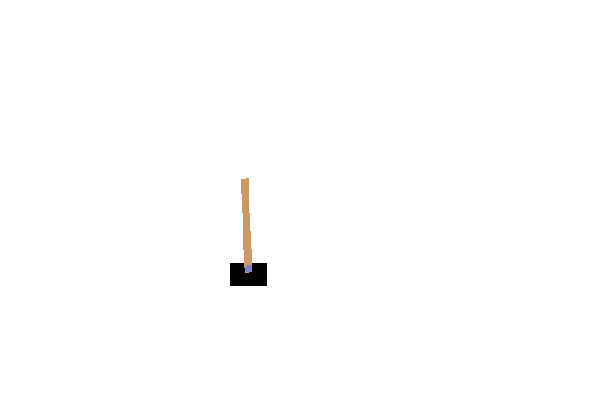
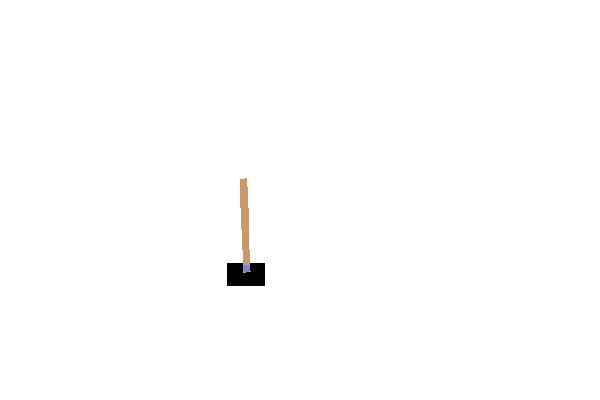
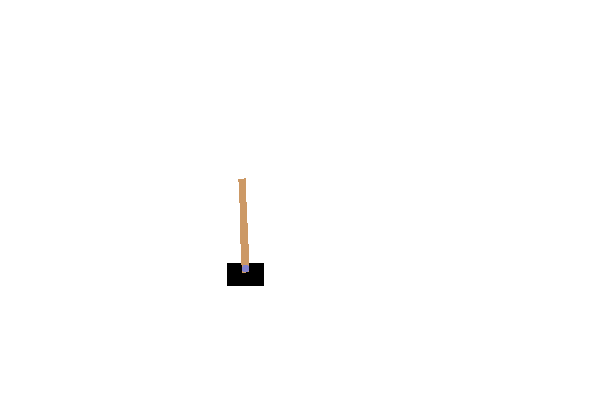
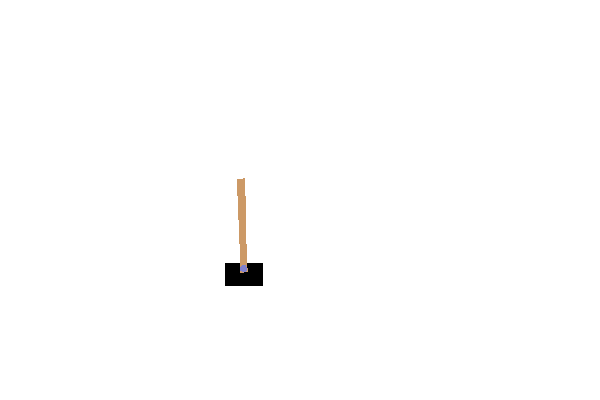
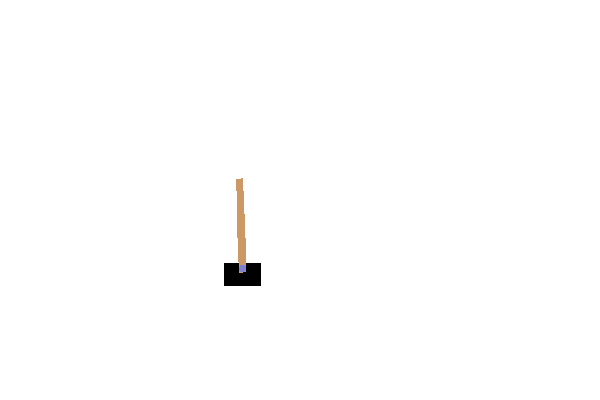
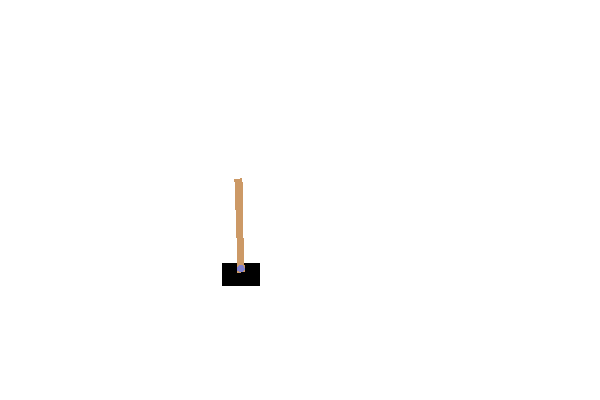
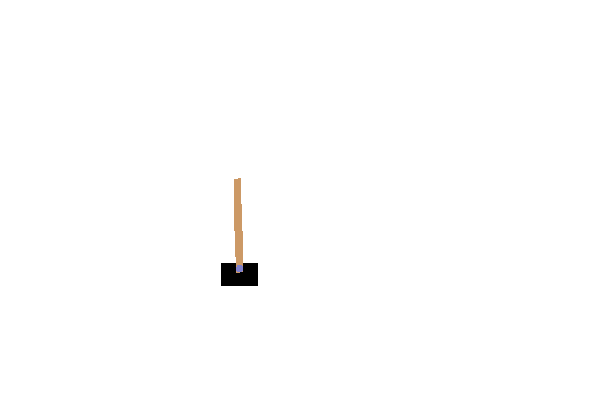
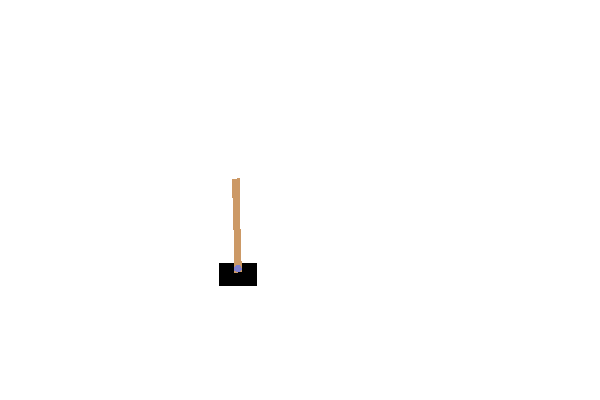
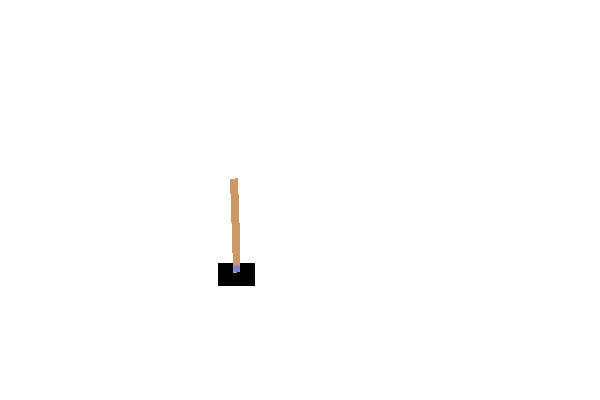
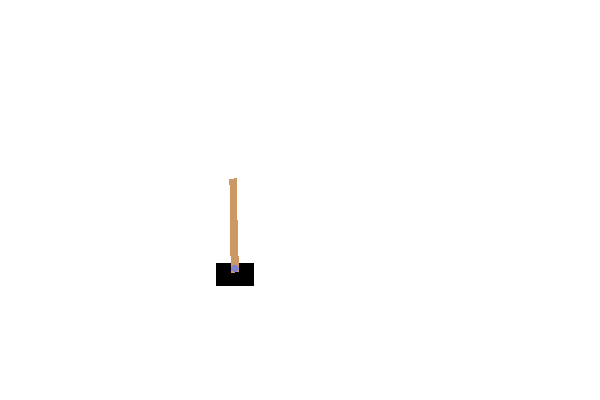
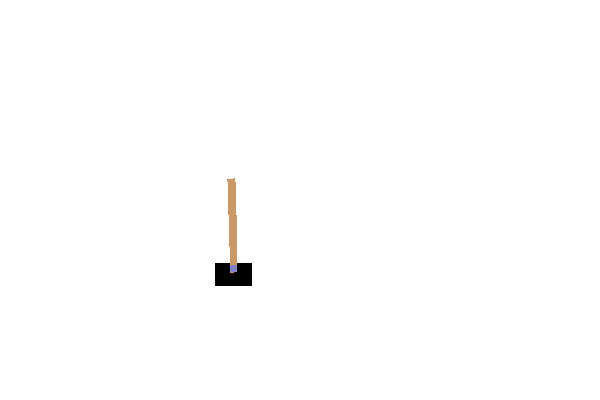
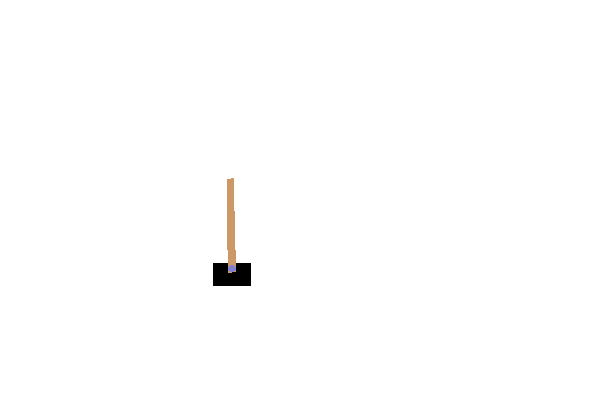
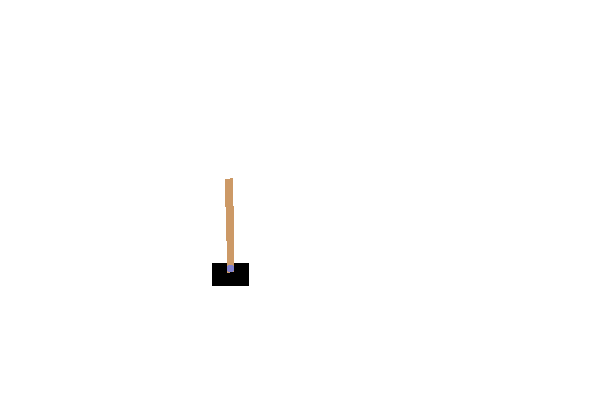
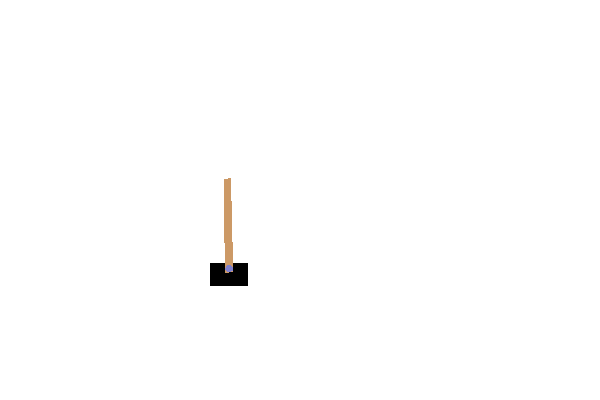
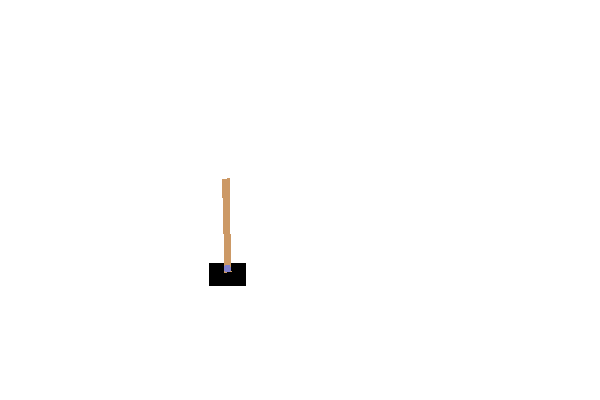
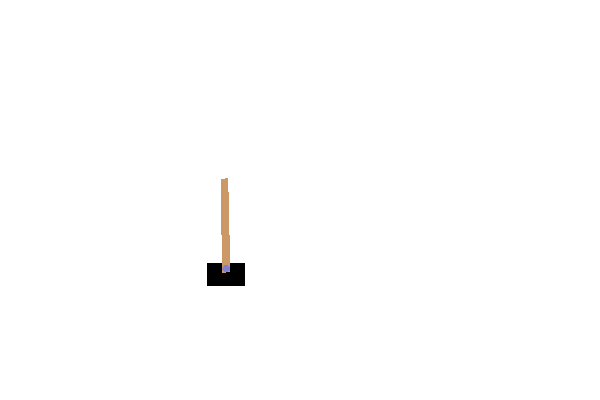
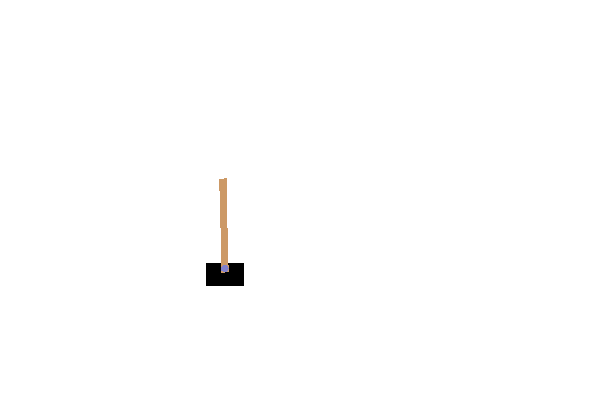
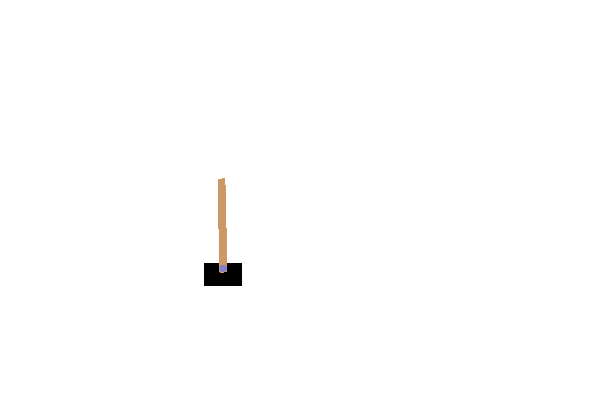
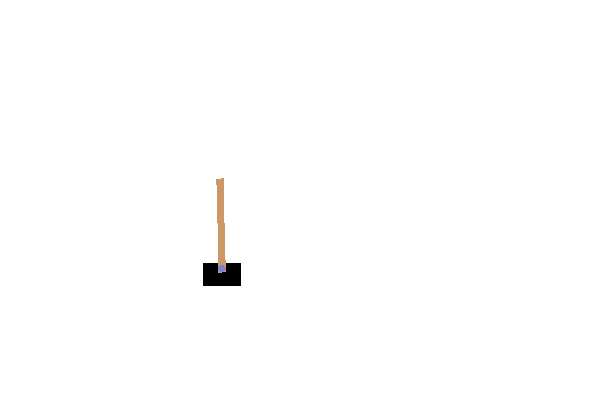
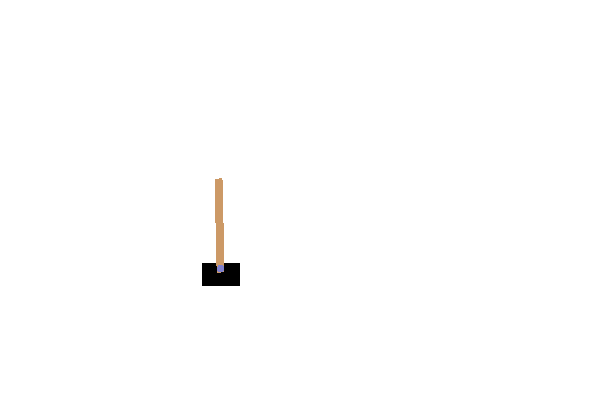
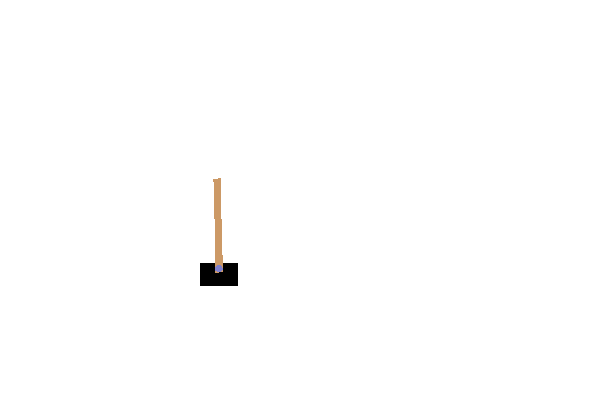
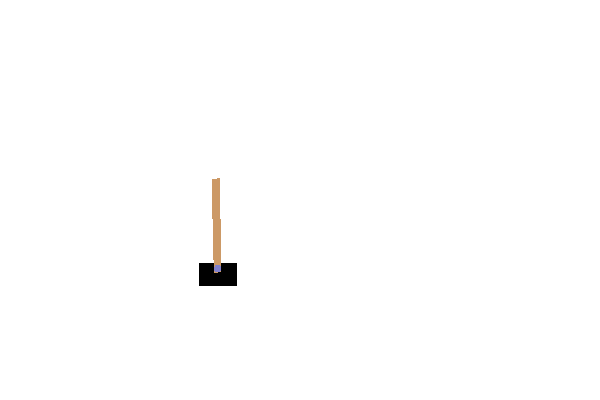
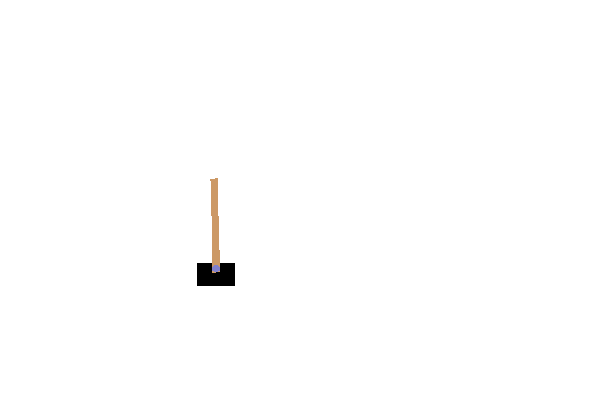
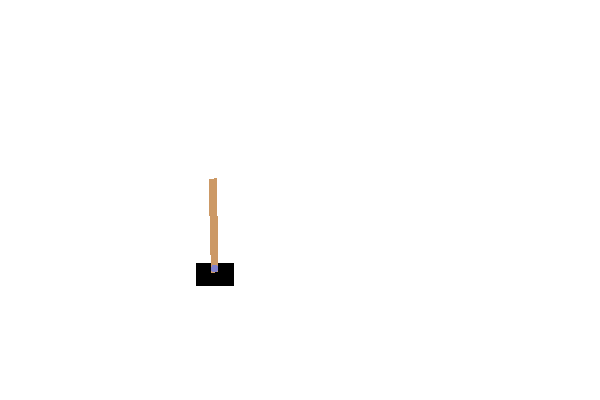
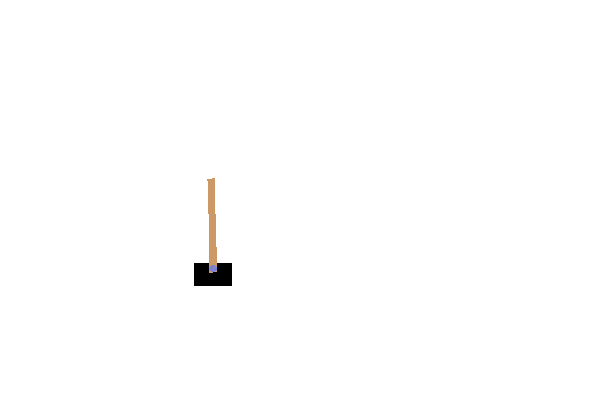
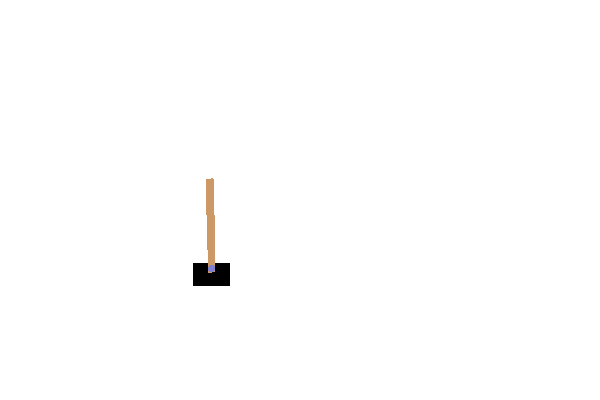
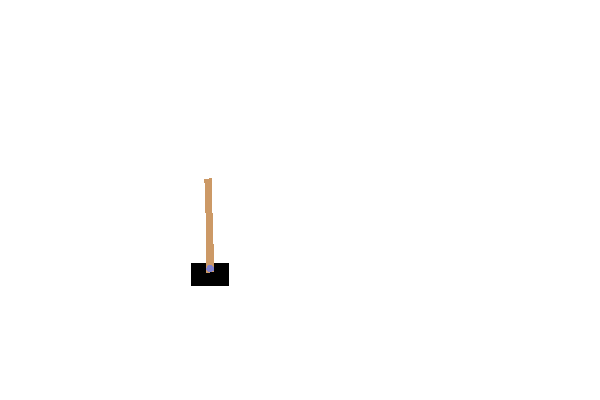
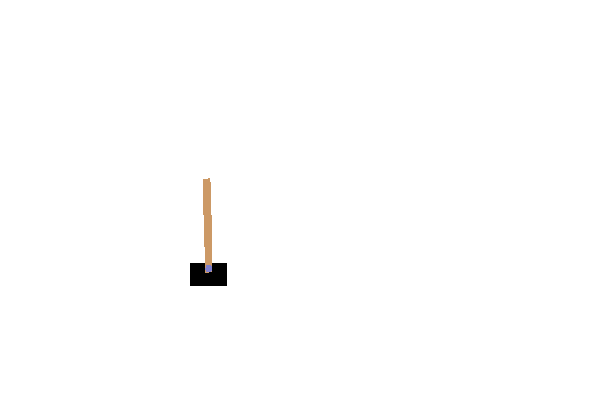
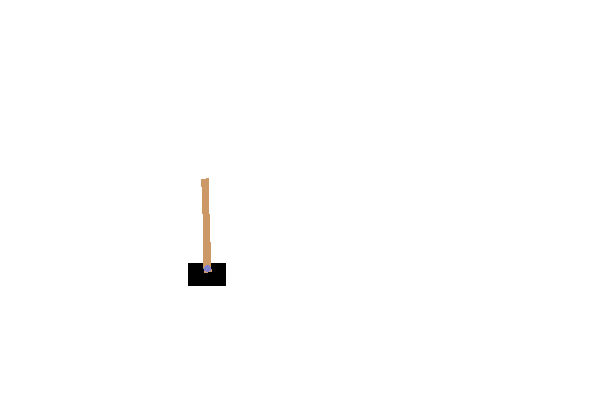
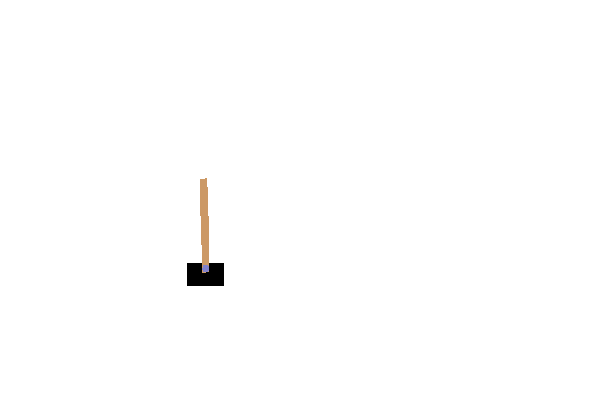
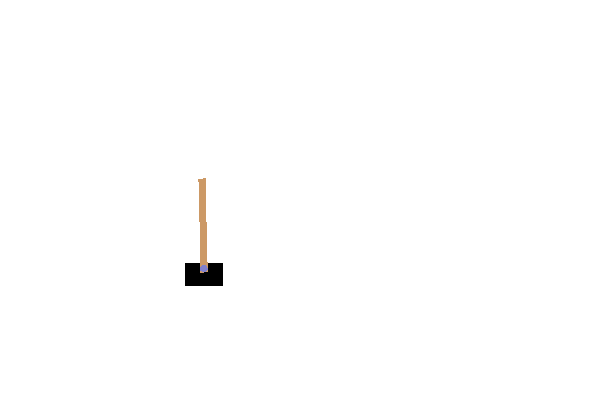
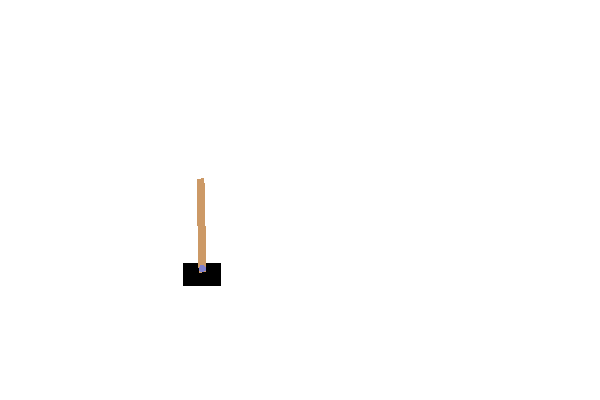
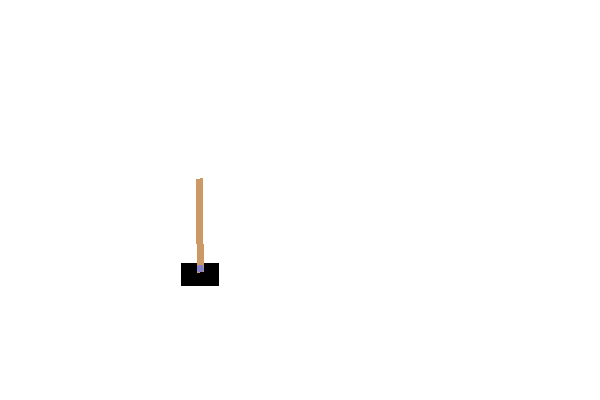
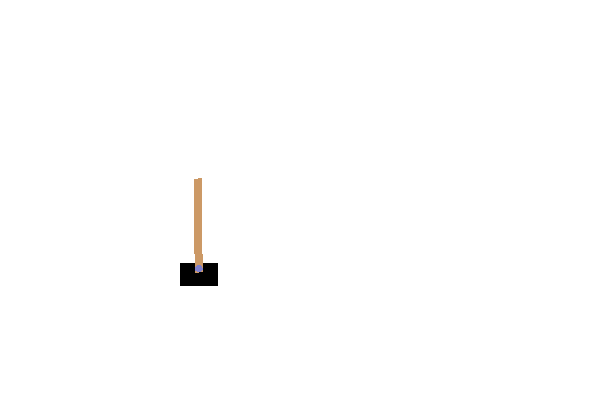
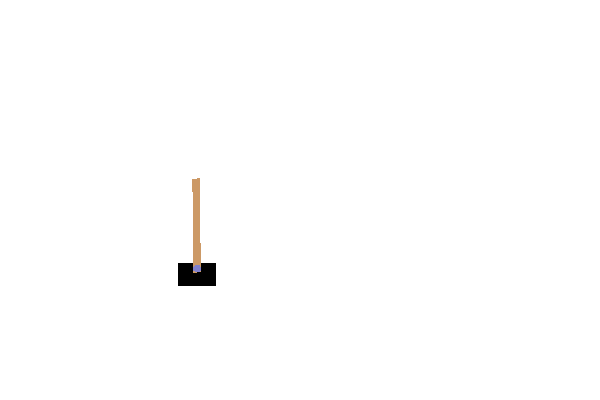
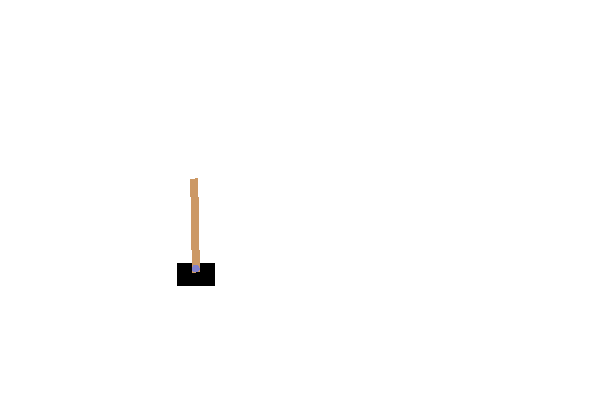
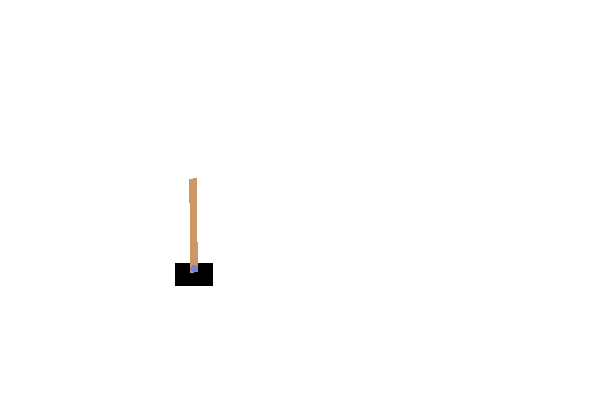
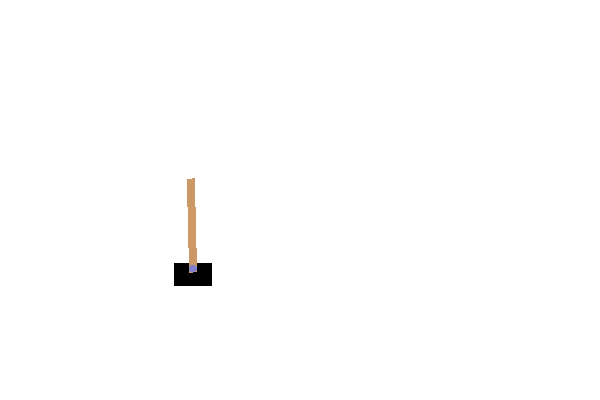
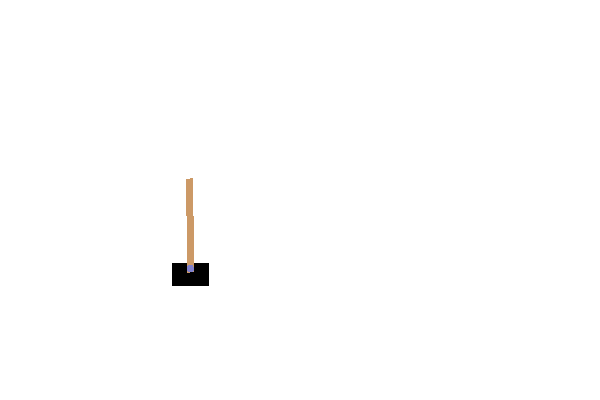
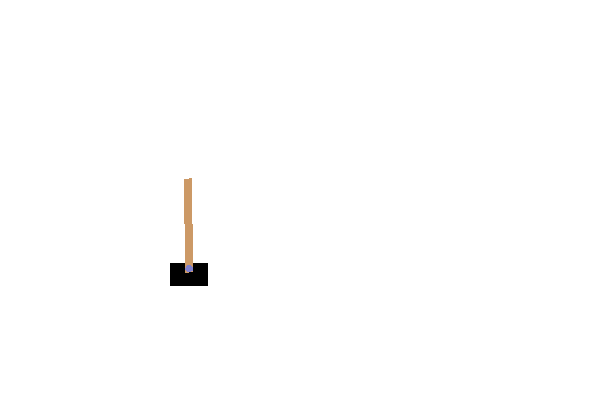
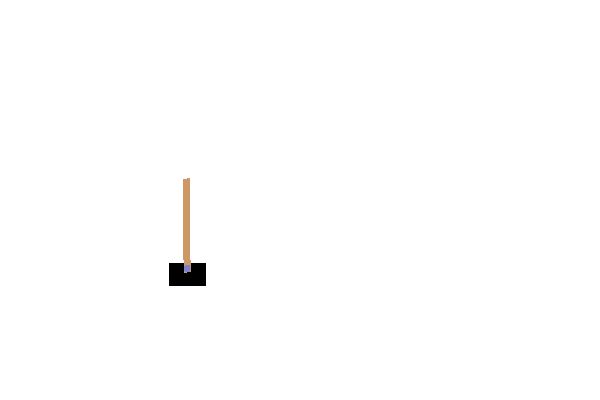
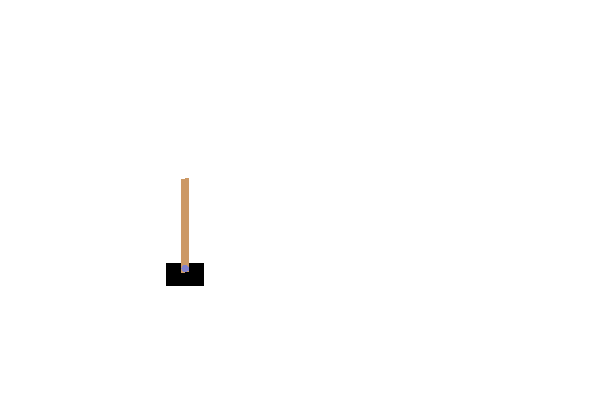
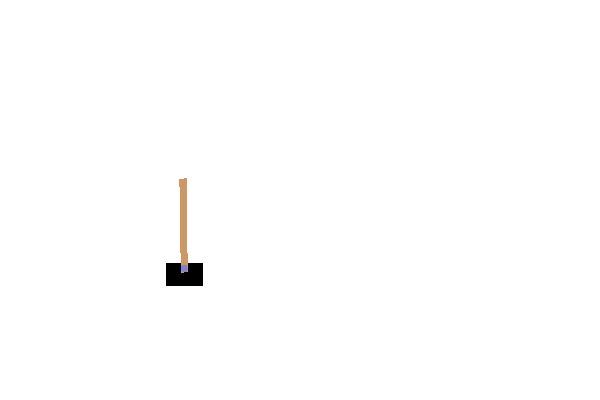
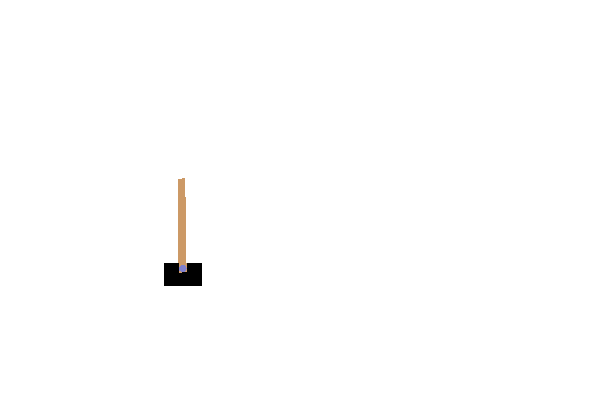
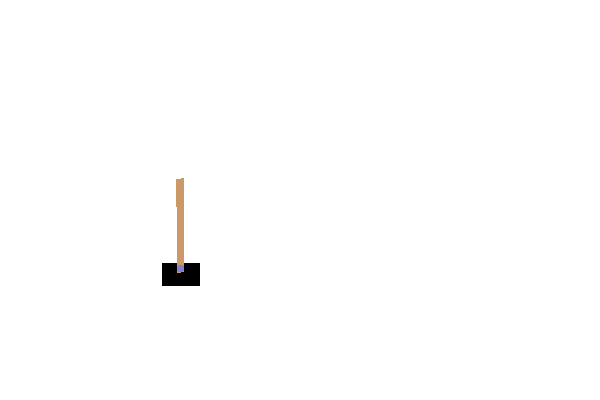
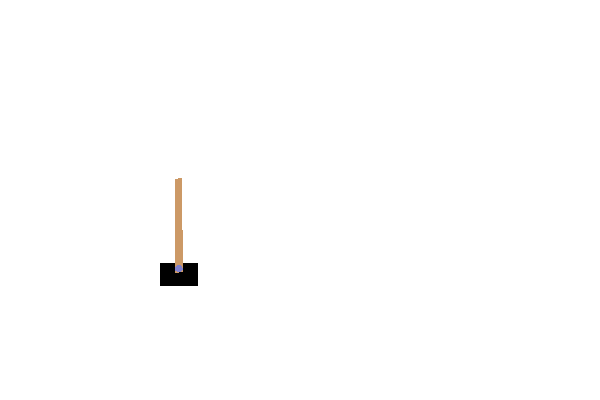
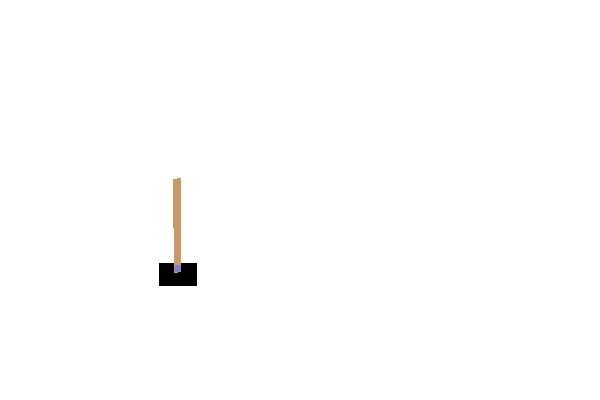
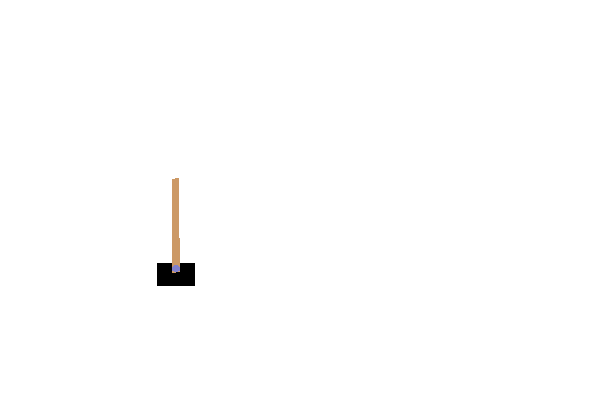
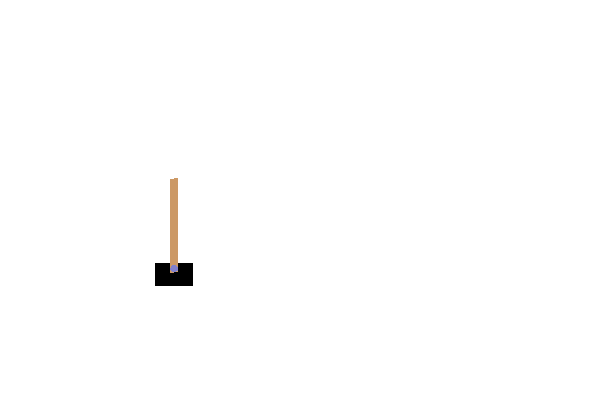
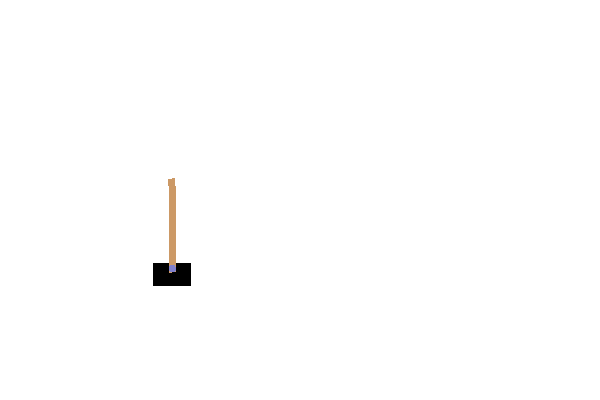
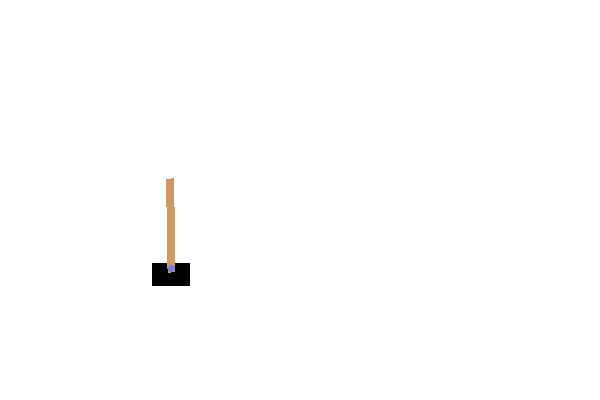
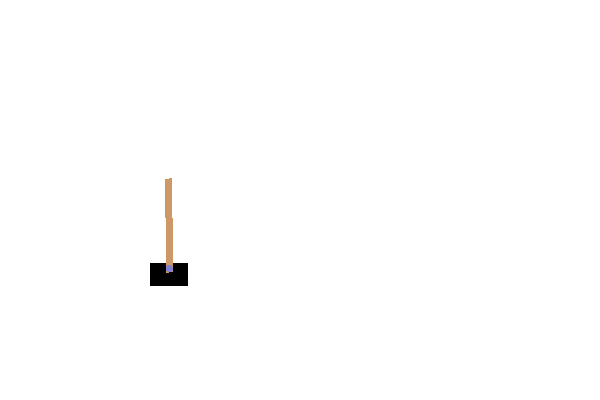
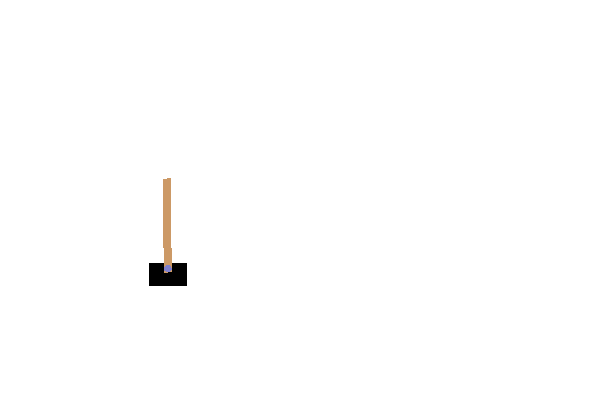
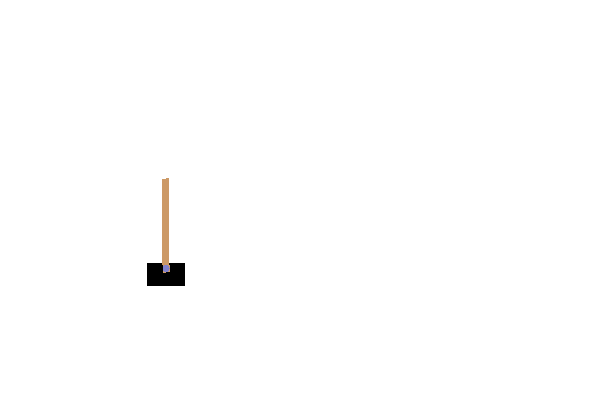
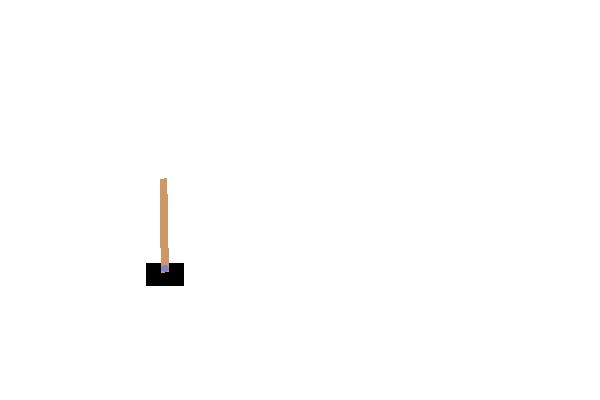
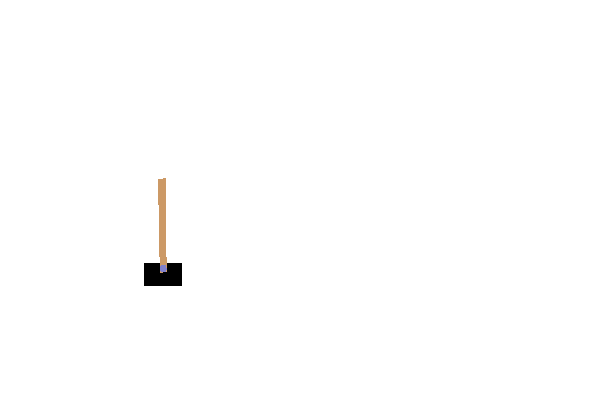
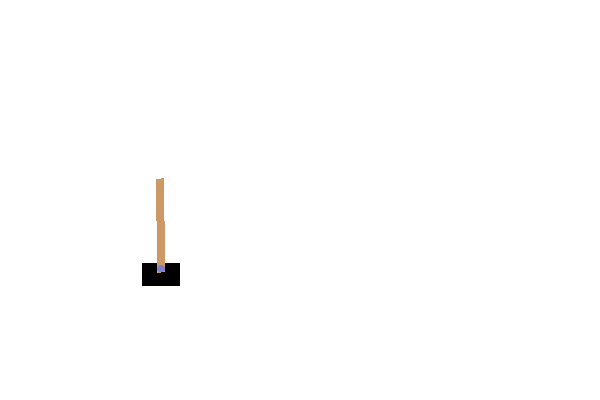
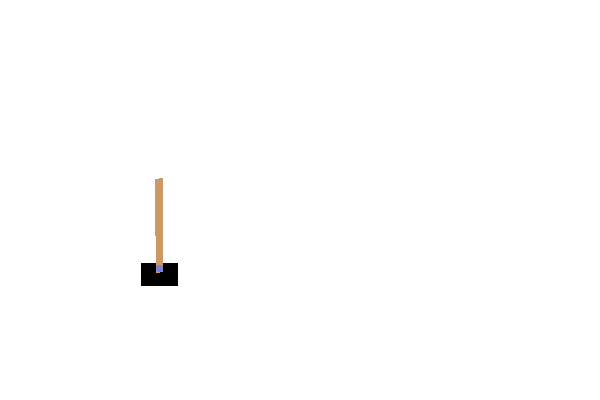
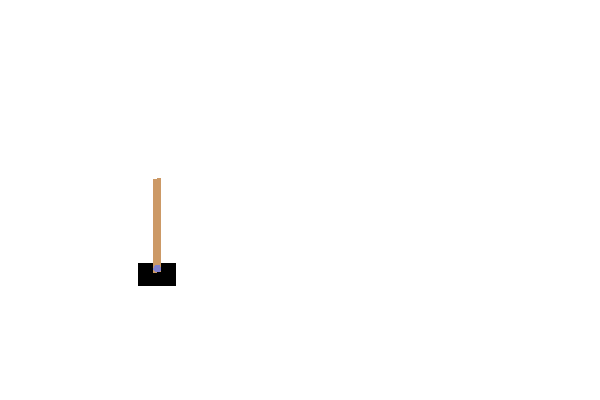
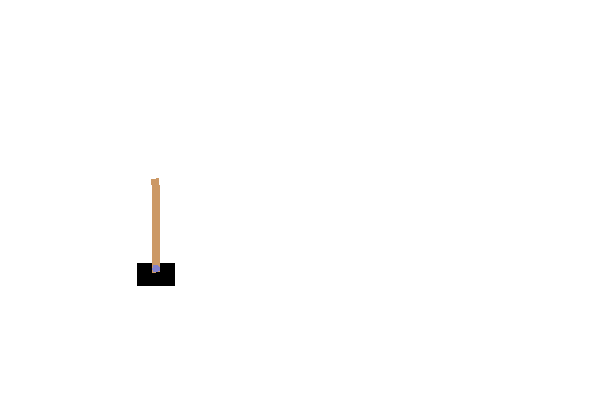
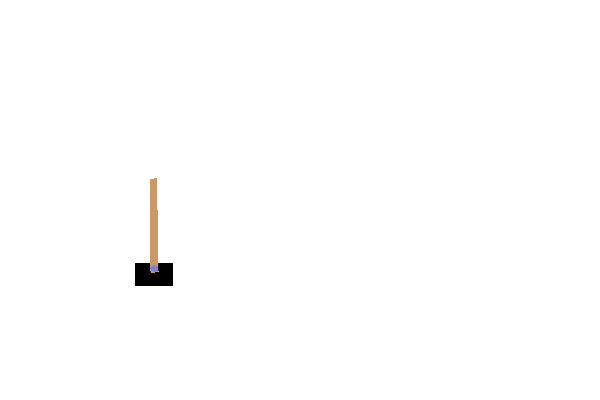
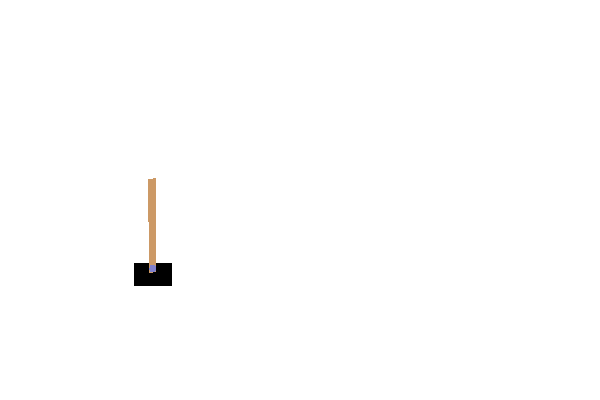
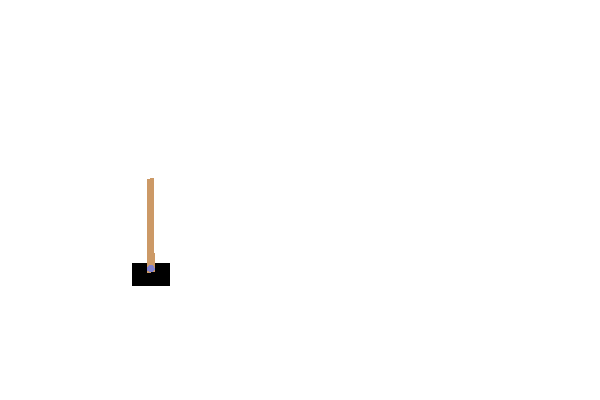
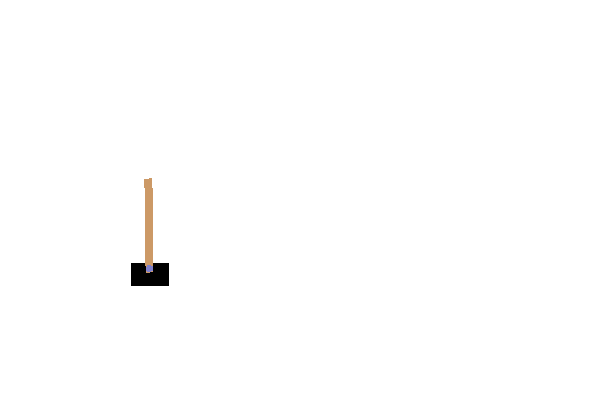
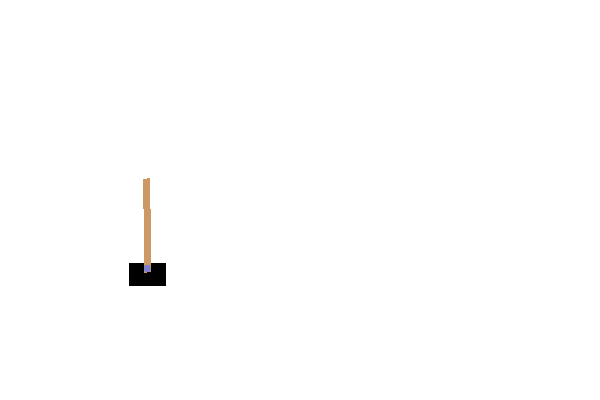
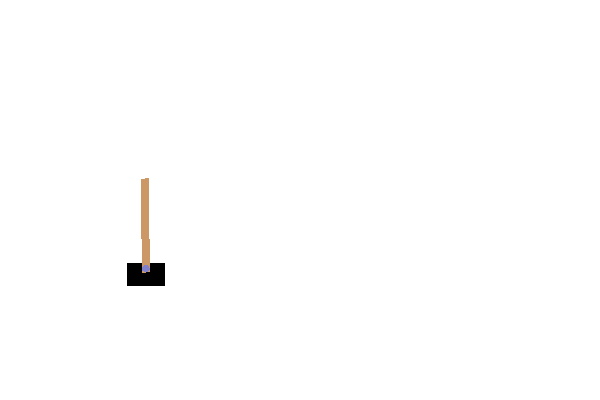
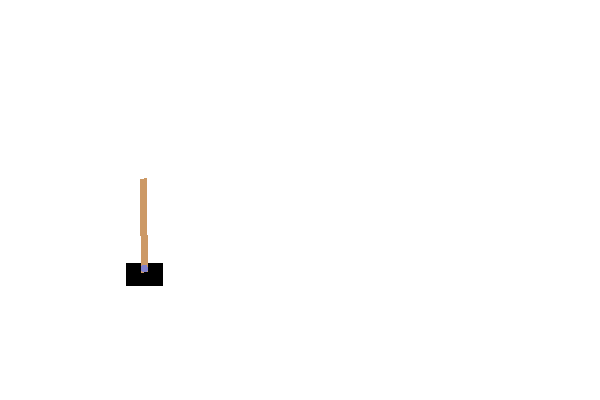
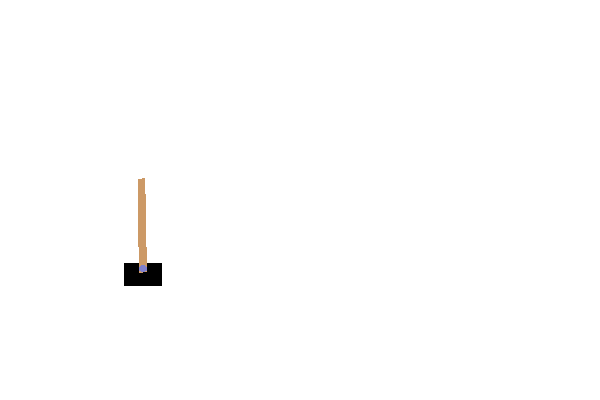
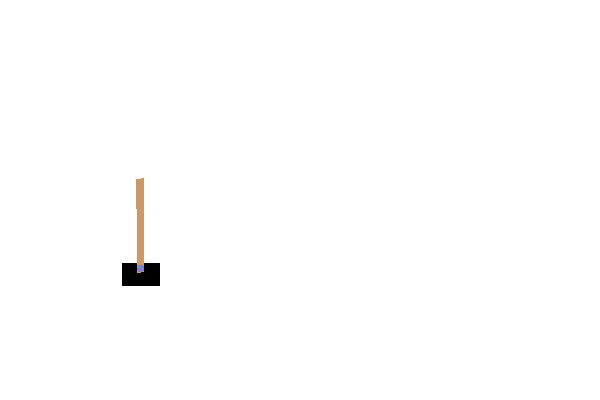
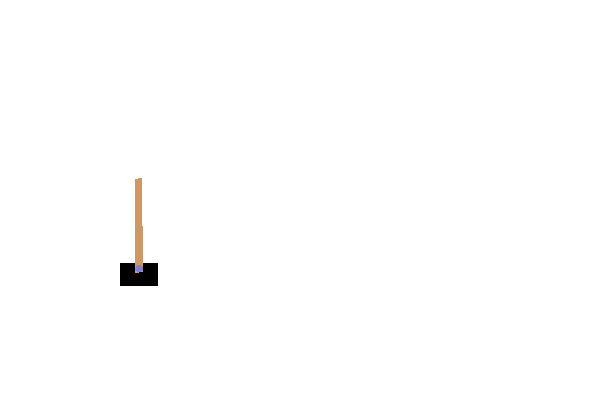
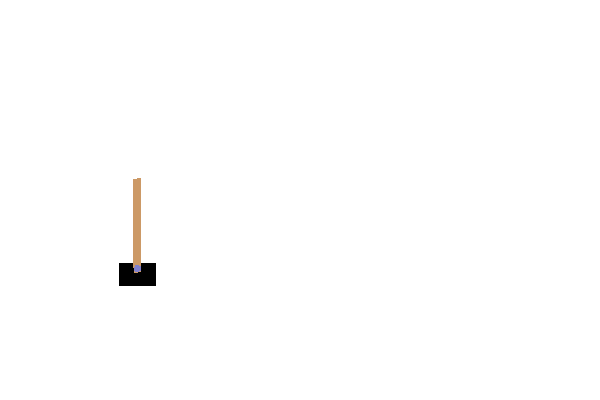
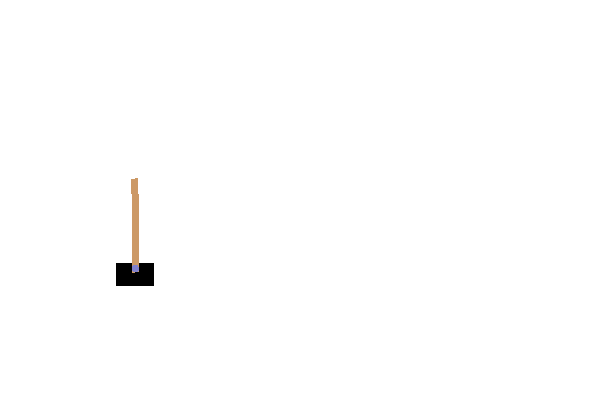
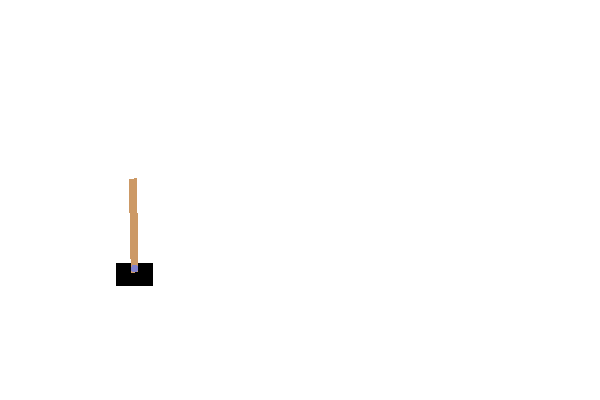
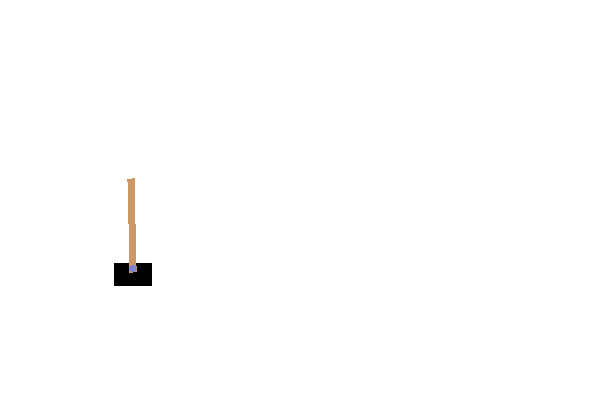
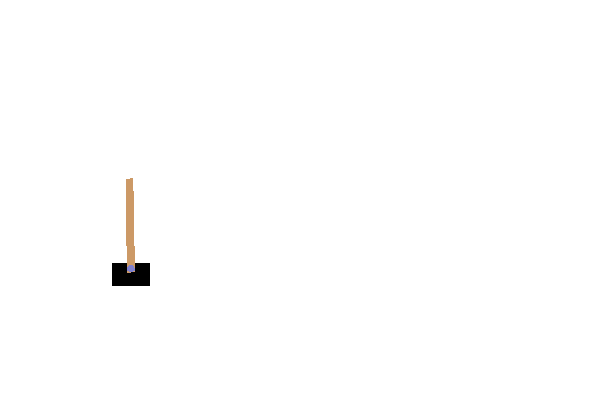
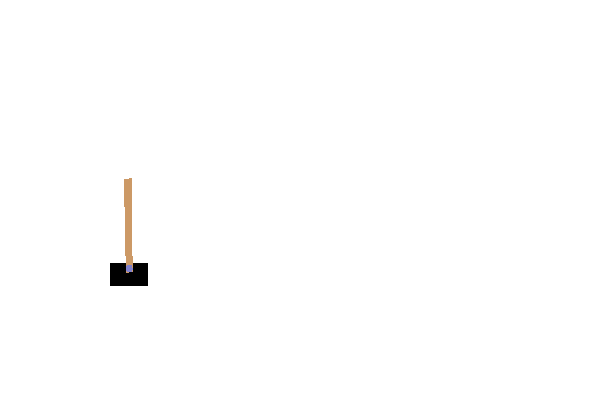
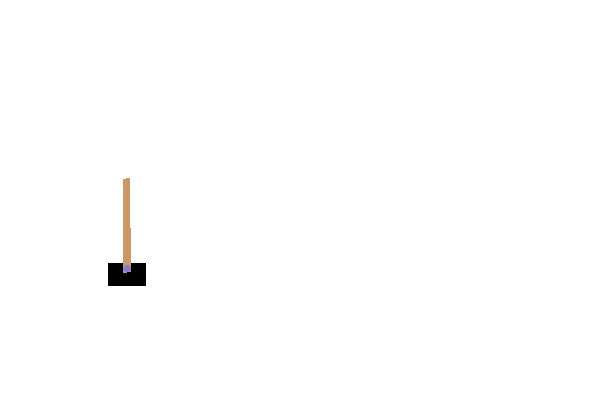
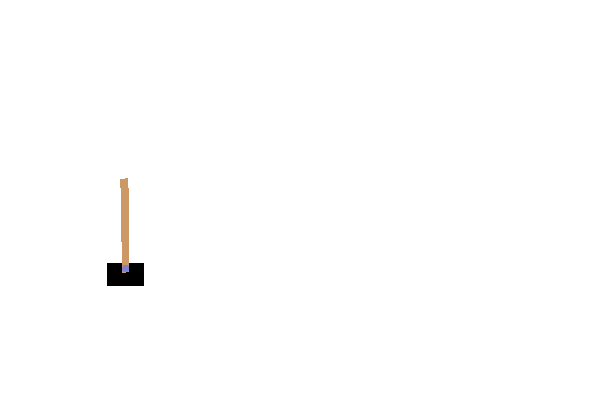
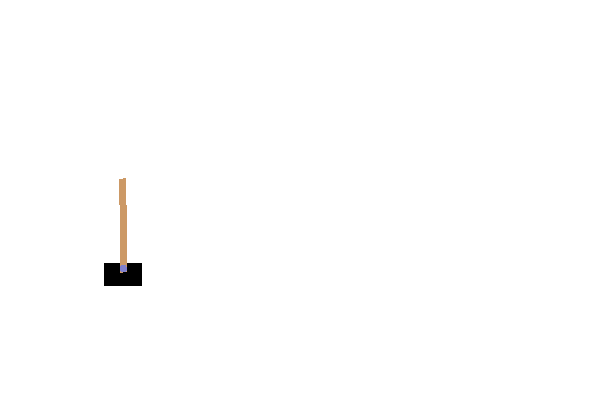
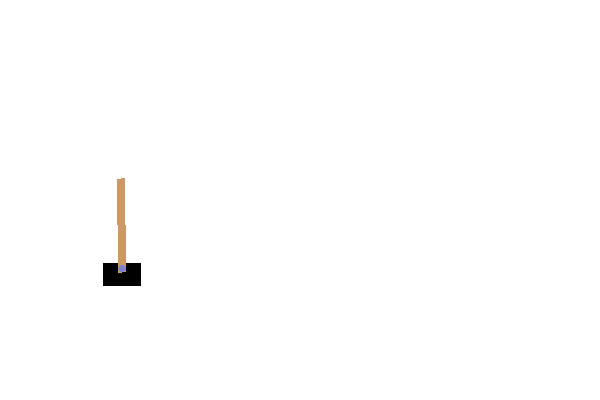
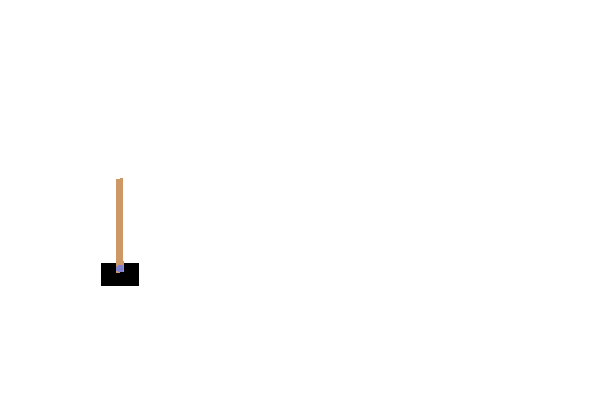
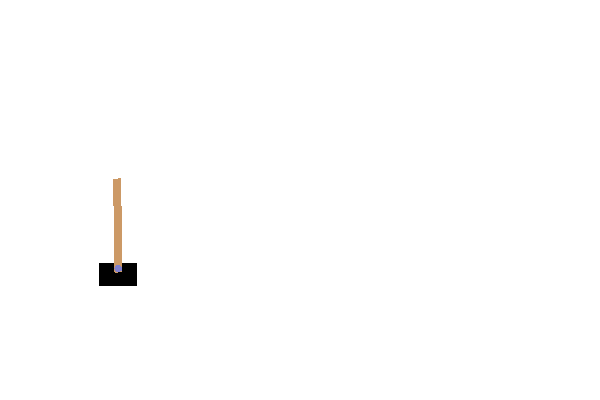
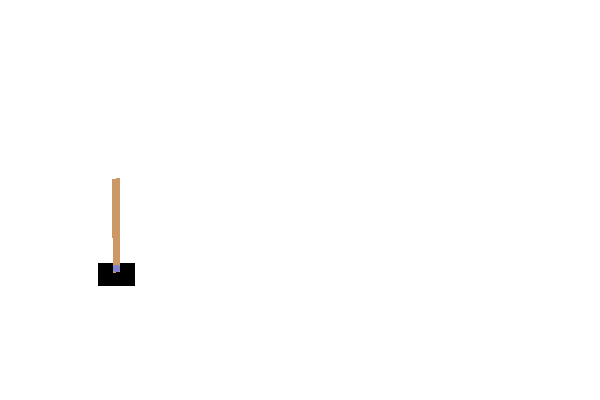
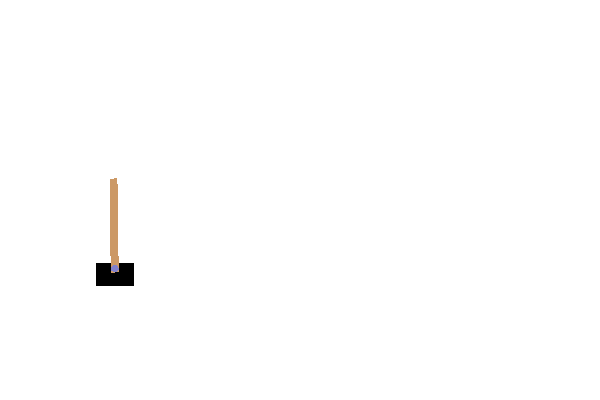
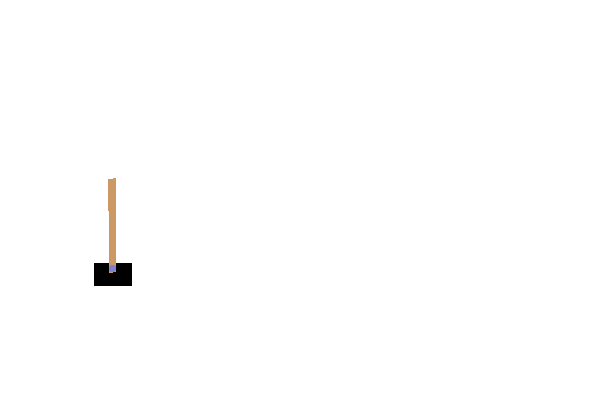
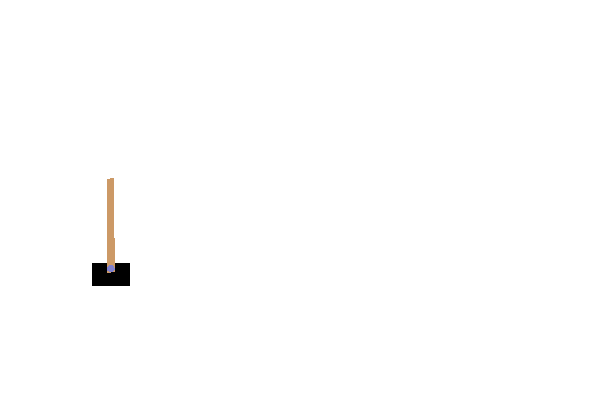
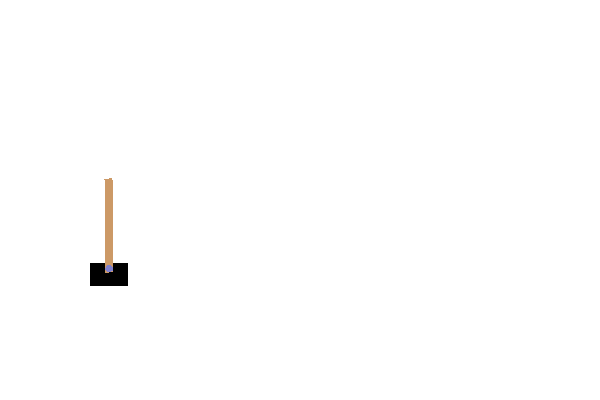
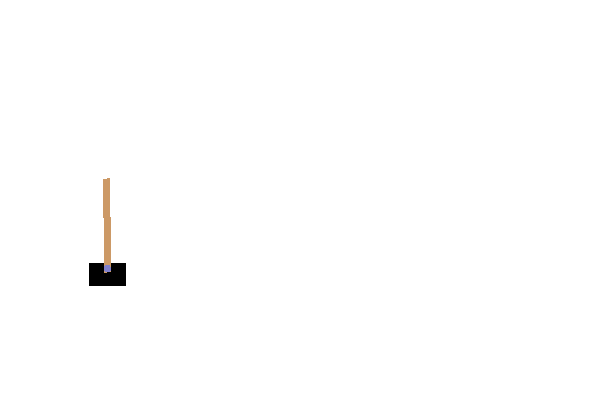
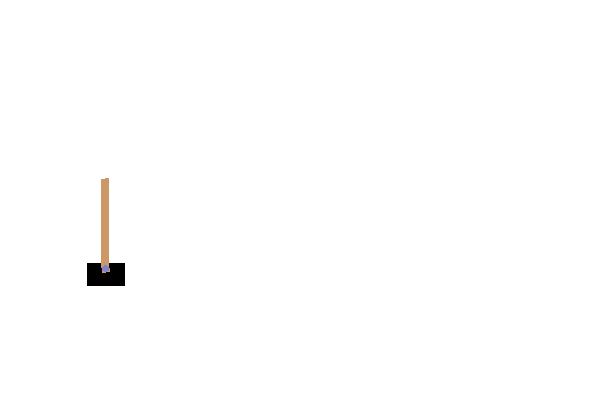
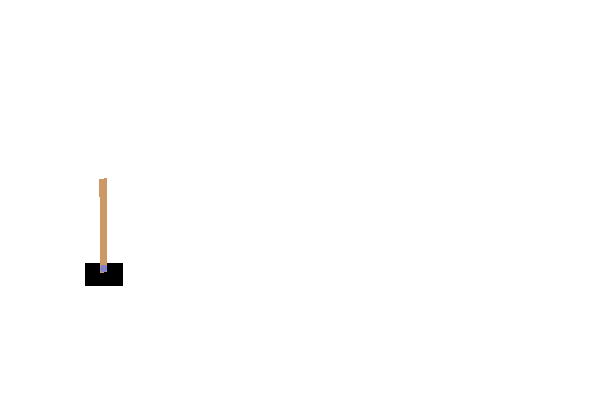
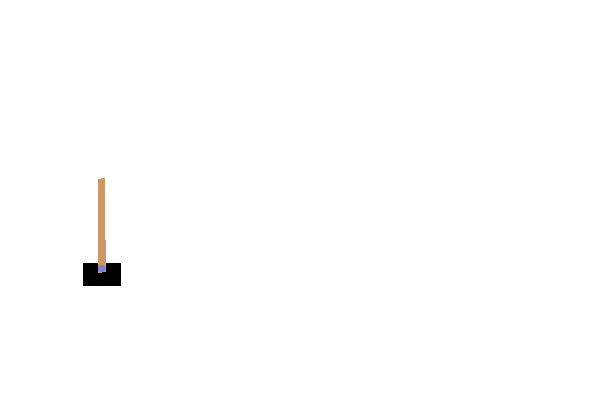
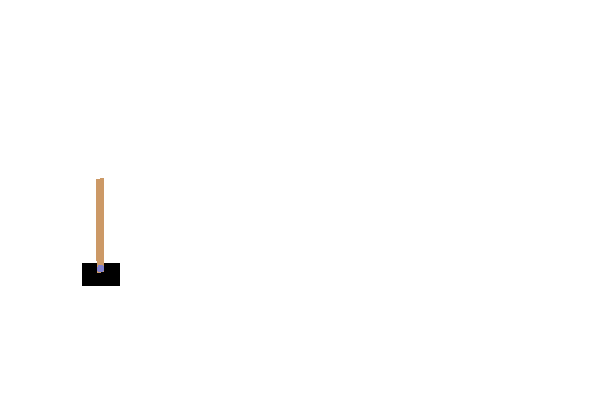
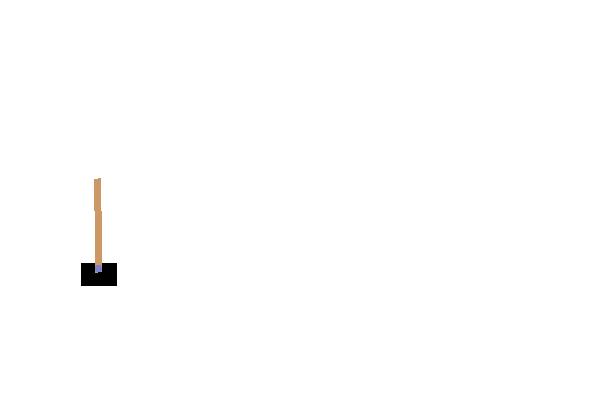
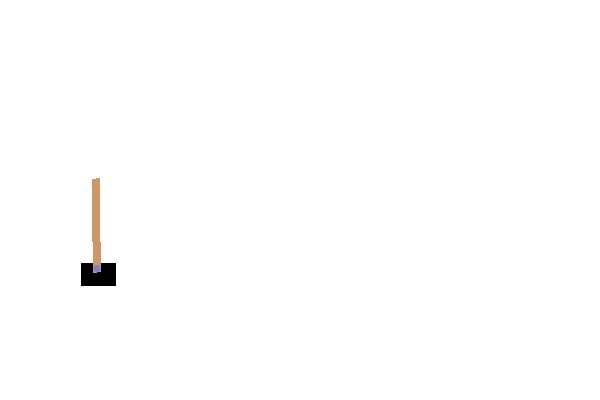
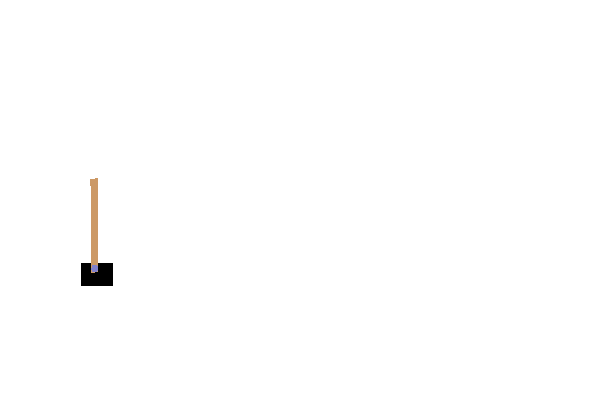
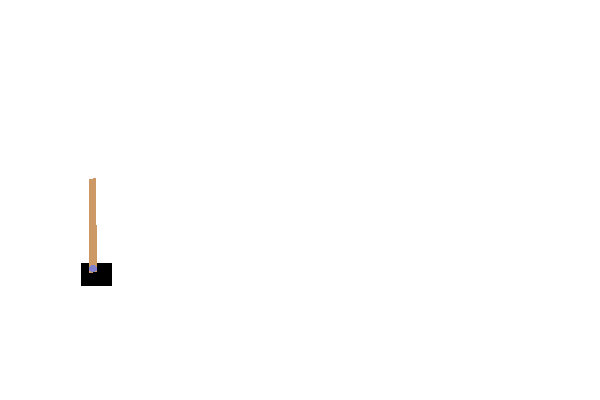
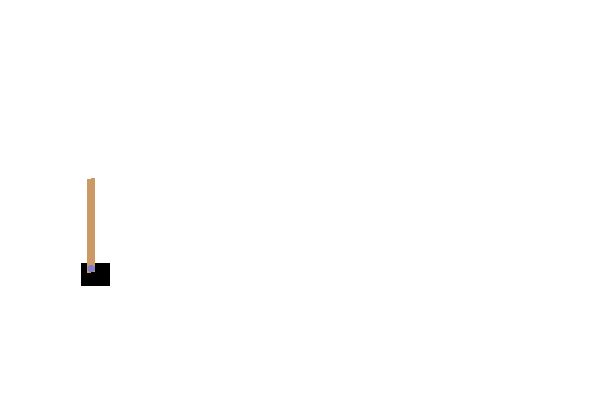
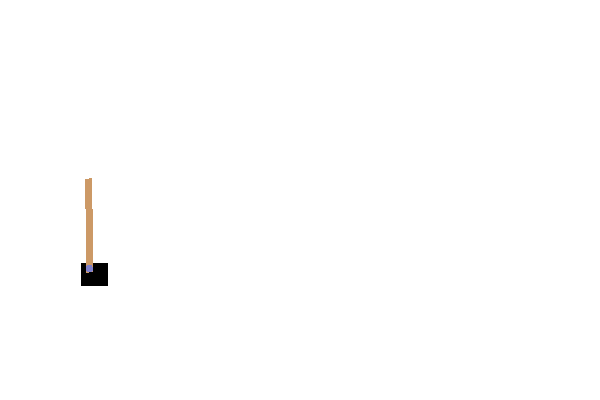
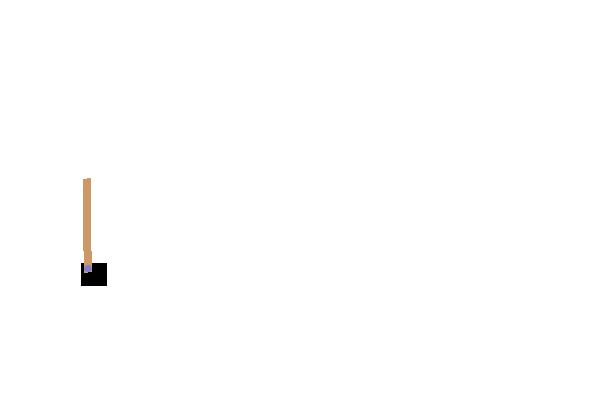
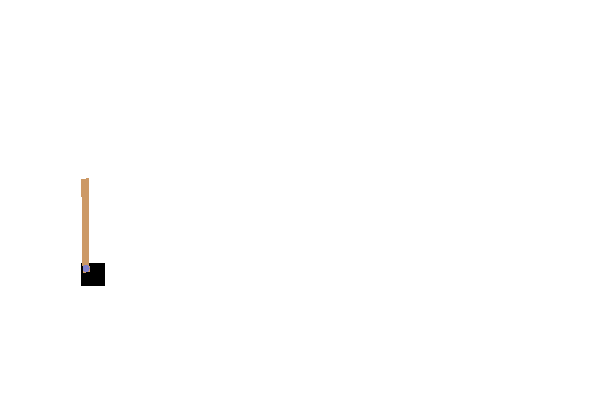
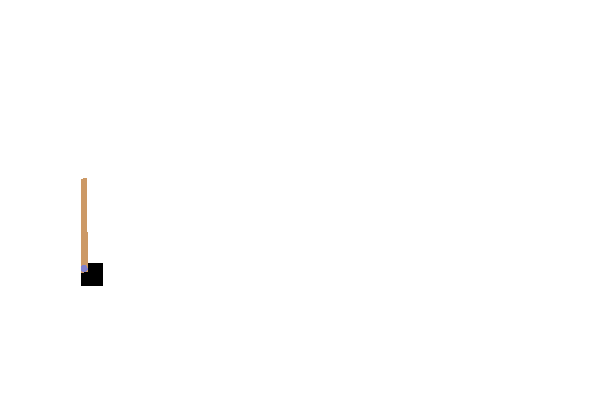
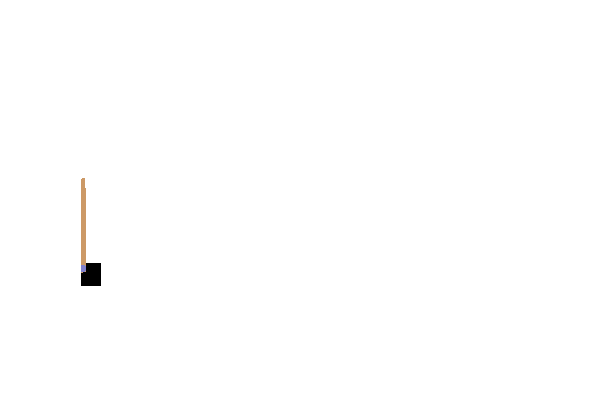

In [15]:
anim = display_frames_as_gif(frames)

In [16]:
save_animation(anim, savepath='double_dqn_cartpole.mp4')

Save animation completed
